In [258]:
import scipy.cluster.hierarchy as sch
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

import math
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [210]:
df_og = pd.read_pickle("datos/exploded_data.pkl")

In [211]:
df = pd.read_pickle("datos/encoded_data.pkl")

In [212]:
num_cols = list(df_og.select_dtypes("number").columns.drop("rank")) + ["number_of_sports"]

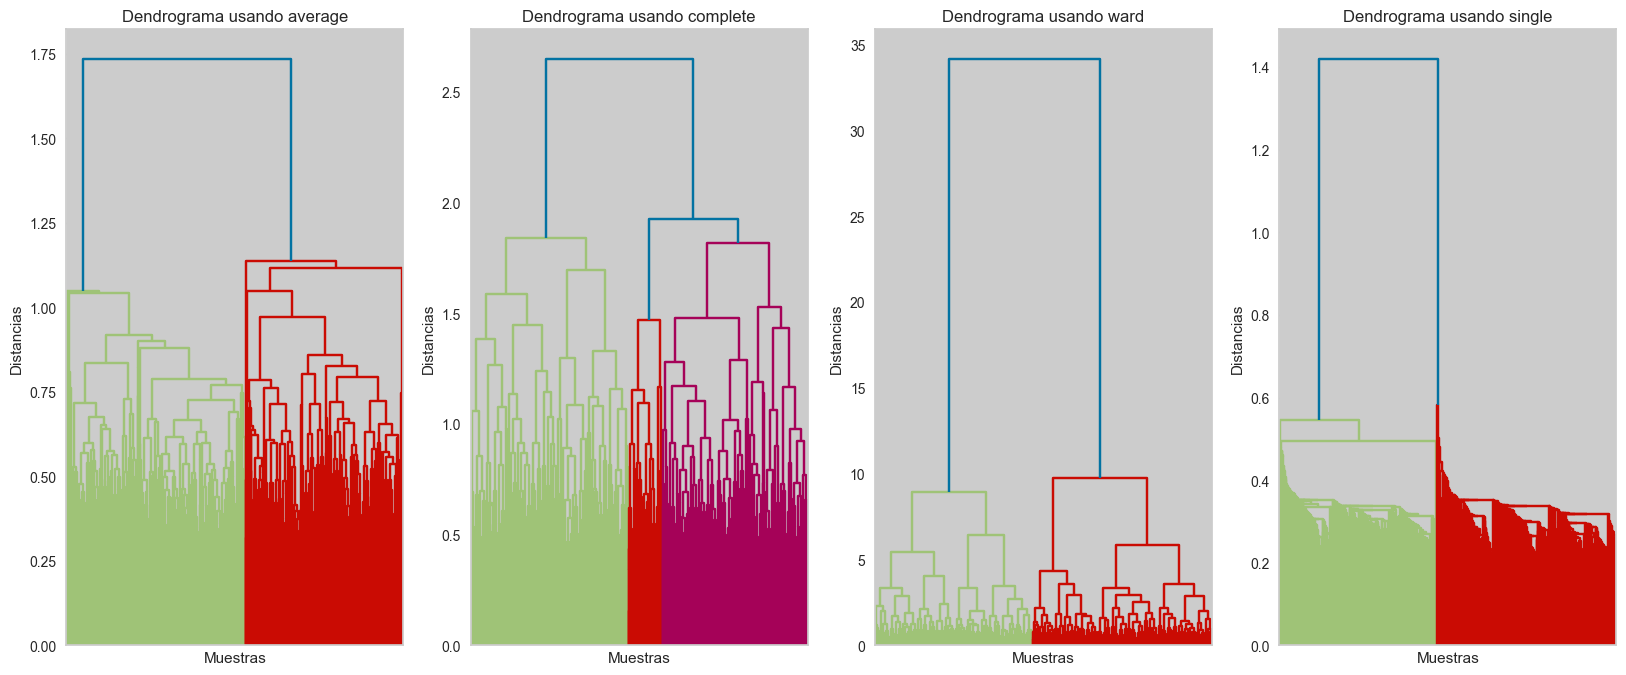

In [213]:
lista_metodos=["average", "complete", "ward", "single"]
_, axes = plt.subplots(nrows=1, ncols=len(lista_metodos), figsize=(20, 8))
axes = axes.flat

for indice, metodo in enumerate(lista_metodos):
    sch.dendrogram(sch.linkage(df, method=metodo),
                    labels=None,
                    leaf_rotation=90, leaf_font_size=4,
                    ax=axes[indice])
    axes[indice].set_title(f'Dendrograma usando {metodo}')
    axes[indice].set_xlabel('Muestras')
    axes[indice].set_ylabel('Distancias')
    axes[indice].tick_params(labelbottom=False)

A la vista de los dendrogramas podemos sacar algunas conclusiones:
- Con average obtenemos unos grupos que intergrupalmente son bastante compactos. Vemos que las distancias entre los 2 clusters generados no son muy altas, lo que indica poca separación intragrupal.
- Con complete ocurre algo similar, pero esta vez obtenemos 3 clusters. Entre el verde y el violeta no hay mucha diferencia, pero el rojo sí que es más diferenciado. Sí que vemos también que entre los grupos hay más distancia.
- Usando el método ward vemos la mayor separación de los grupos, formando 2 clusters.
- Con single vemos un efecto de encadenamiento, donde los clusters se van formando encadenando datos similares, obteniendo 2 clusters no muy separados.

### Agglomerative Clustering

Vamos a ver qué método nos podría ser conveniente analizando las métricas:

In [214]:
# Configuraciones de vinculación y métricas de distancia
linkage_methods = lista_metodos
distance_metrics = ['euclidean', 'cosine', 'chebyshev']

# Crear un DataFrame para almacenar los resultados
results = []
df_copia = df.copy()
# Suponiendo que tienes un DataFrame llamado df_copia
# Aquí df_copia debería ser tu conjunto de datos
# Asegúrate de que esté preprocesado adecuadamente (normalizado si es necesario)

for linkage_method in linkage_methods:
    for metric in distance_metrics:
        for cluster in range(2,10):
            try:
                # Configurar el modelo de AgglomerativeClustering
                modelo = AgglomerativeClustering(
                    linkage=linkage_method,
                    metric=metric,  
                    distance_threshold=None,  # Para buscar n_clusters
                    n_clusters=cluster, # Cambia esto según tu análisis
                )
                
                # Ajustar el modelo
                labels = modelo.fit_predict(df_copia)

                # Calcular métricas si hay más de un cluster
                if len(np.unique(labels)) > 1:
                    # Silhouette Score
                    silhouette_avg = silhouette_score(df_copia, labels, metric=metric)

                    # Davies-Bouldin Index
                    db_score = davies_bouldin_score(df_copia, labels)

                    
                    # Cardinalidad (tamaño de cada cluster)
                    cluster_cardinality = {cluster: sum(labels == cluster) for cluster in np.unique(labels)}

                # Almacenar resultados
                results.append({
                    'linkage': linkage_method,
                    'metric': metric,
                    'silhouette_score': silhouette_avg,
                    'davies_bouldin_index': db_score,
                    'cluster_cardinality': cluster_cardinality,
                    'n_cluster': cluster
                })

            except Exception as e:
                continue
                # print(f"Error con linkage={linkage_method}, metric={metric}: {e}")

# Crear DataFrame de resultados
results_df = pd.DataFrame(results)

# Mostrar resultados ordenados por silhouette_score
results_df = results_df.sort_values(by='silhouette_score', ascending=False).reset_index(drop = True)

# Mostrar el DataFrame
results_df.head(20)

,linkage,metric,silhouette_score,davies_bouldin_index,cluster_cardinality,n_cluster
0,average,cosine,0.760531,0.802394,"{0: 552, 1: 486}",2
1,single,cosine,0.760531,0.802394,"{0: 552, 1: 486}",2
2,complete,cosine,0.760531,0.802394,"{0: 552, 1: 486}",2
3,single,cosine,0.623825,0.715858,"{0: 486, 1: 551, 2: 1}",3
4,average,cosine,0.576817,0.728897,"{0: 551, 1: 486, 2: 1}",3
5,complete,cosine,0.536622,1.474749,"{0: 252, 1: 486, 2: 300}",3
6,average,cosine,0.517490,1.154146,"{0: 184, 1: 486, 2: 1, 3: 3, 4: 364}",5
7,average,euclidean,0.514486,0.802394,"{0: 486, 1: 552}",2
8,complete,euclidean,0.514486,0.802394,"{0: 552, 1: 486}",2
9,single,euclidean,0.514486,0.802394,"{0: 552, 1: 486}",2


En general las métricas sugieren 2 clusters, pero hay opciones con más. Probemos las 6 primeras:

In [215]:
df_with_labels = df.copy()
for link, metric, k in results_df.head(6)[["linkage", "metric","n_cluster"]].values:
    agglomerative = AgglomerativeClustering(n_clusters=k, linkage=link, metric=metric)
    agglomerative.fit(df)
    df_with_labels[f"{link}-{metric}-{k}"] = agglomerative.labels_

In [216]:
df_with_labels.head()

,gender,age,height,weight,sports,hours_per_day,strength,agility,mental,year_start,number_of_sports,cluster,average-cosine-2,single-cosine-2,complete-cosine-2,single-cosine-3,average-cosine-3,complete-cosine-3
0,1.0,0.657143,0.26,0.293103,1.000000,0.375,0.625,0.714286,0.571429,0.085714,0.25,0,0,0,0,1,0,2
1,1.0,0.657143,0.26,0.293103,0.492958,0.375,0.625,0.714286,0.571429,0.085714,0.25,0,0,0,0,1,0,2
2,0.0,0.514286,0.66,0.603448,0.000000,0.000,0.750,0.285714,0.857143,0.571429,0.00,1,1,1,1,0,1,1
3,0.0,0.314286,0.53,0.482759,0.647887,0.500,0.750,0.714286,0.571429,0.742857,0.00,1,1,1,1,0,1,1
4,0.0,0.600000,0.71,0.724138,0.000000,0.375,0.625,0.428571,0.714286,0.485714,0.00,1,1,1,1,0,1,1


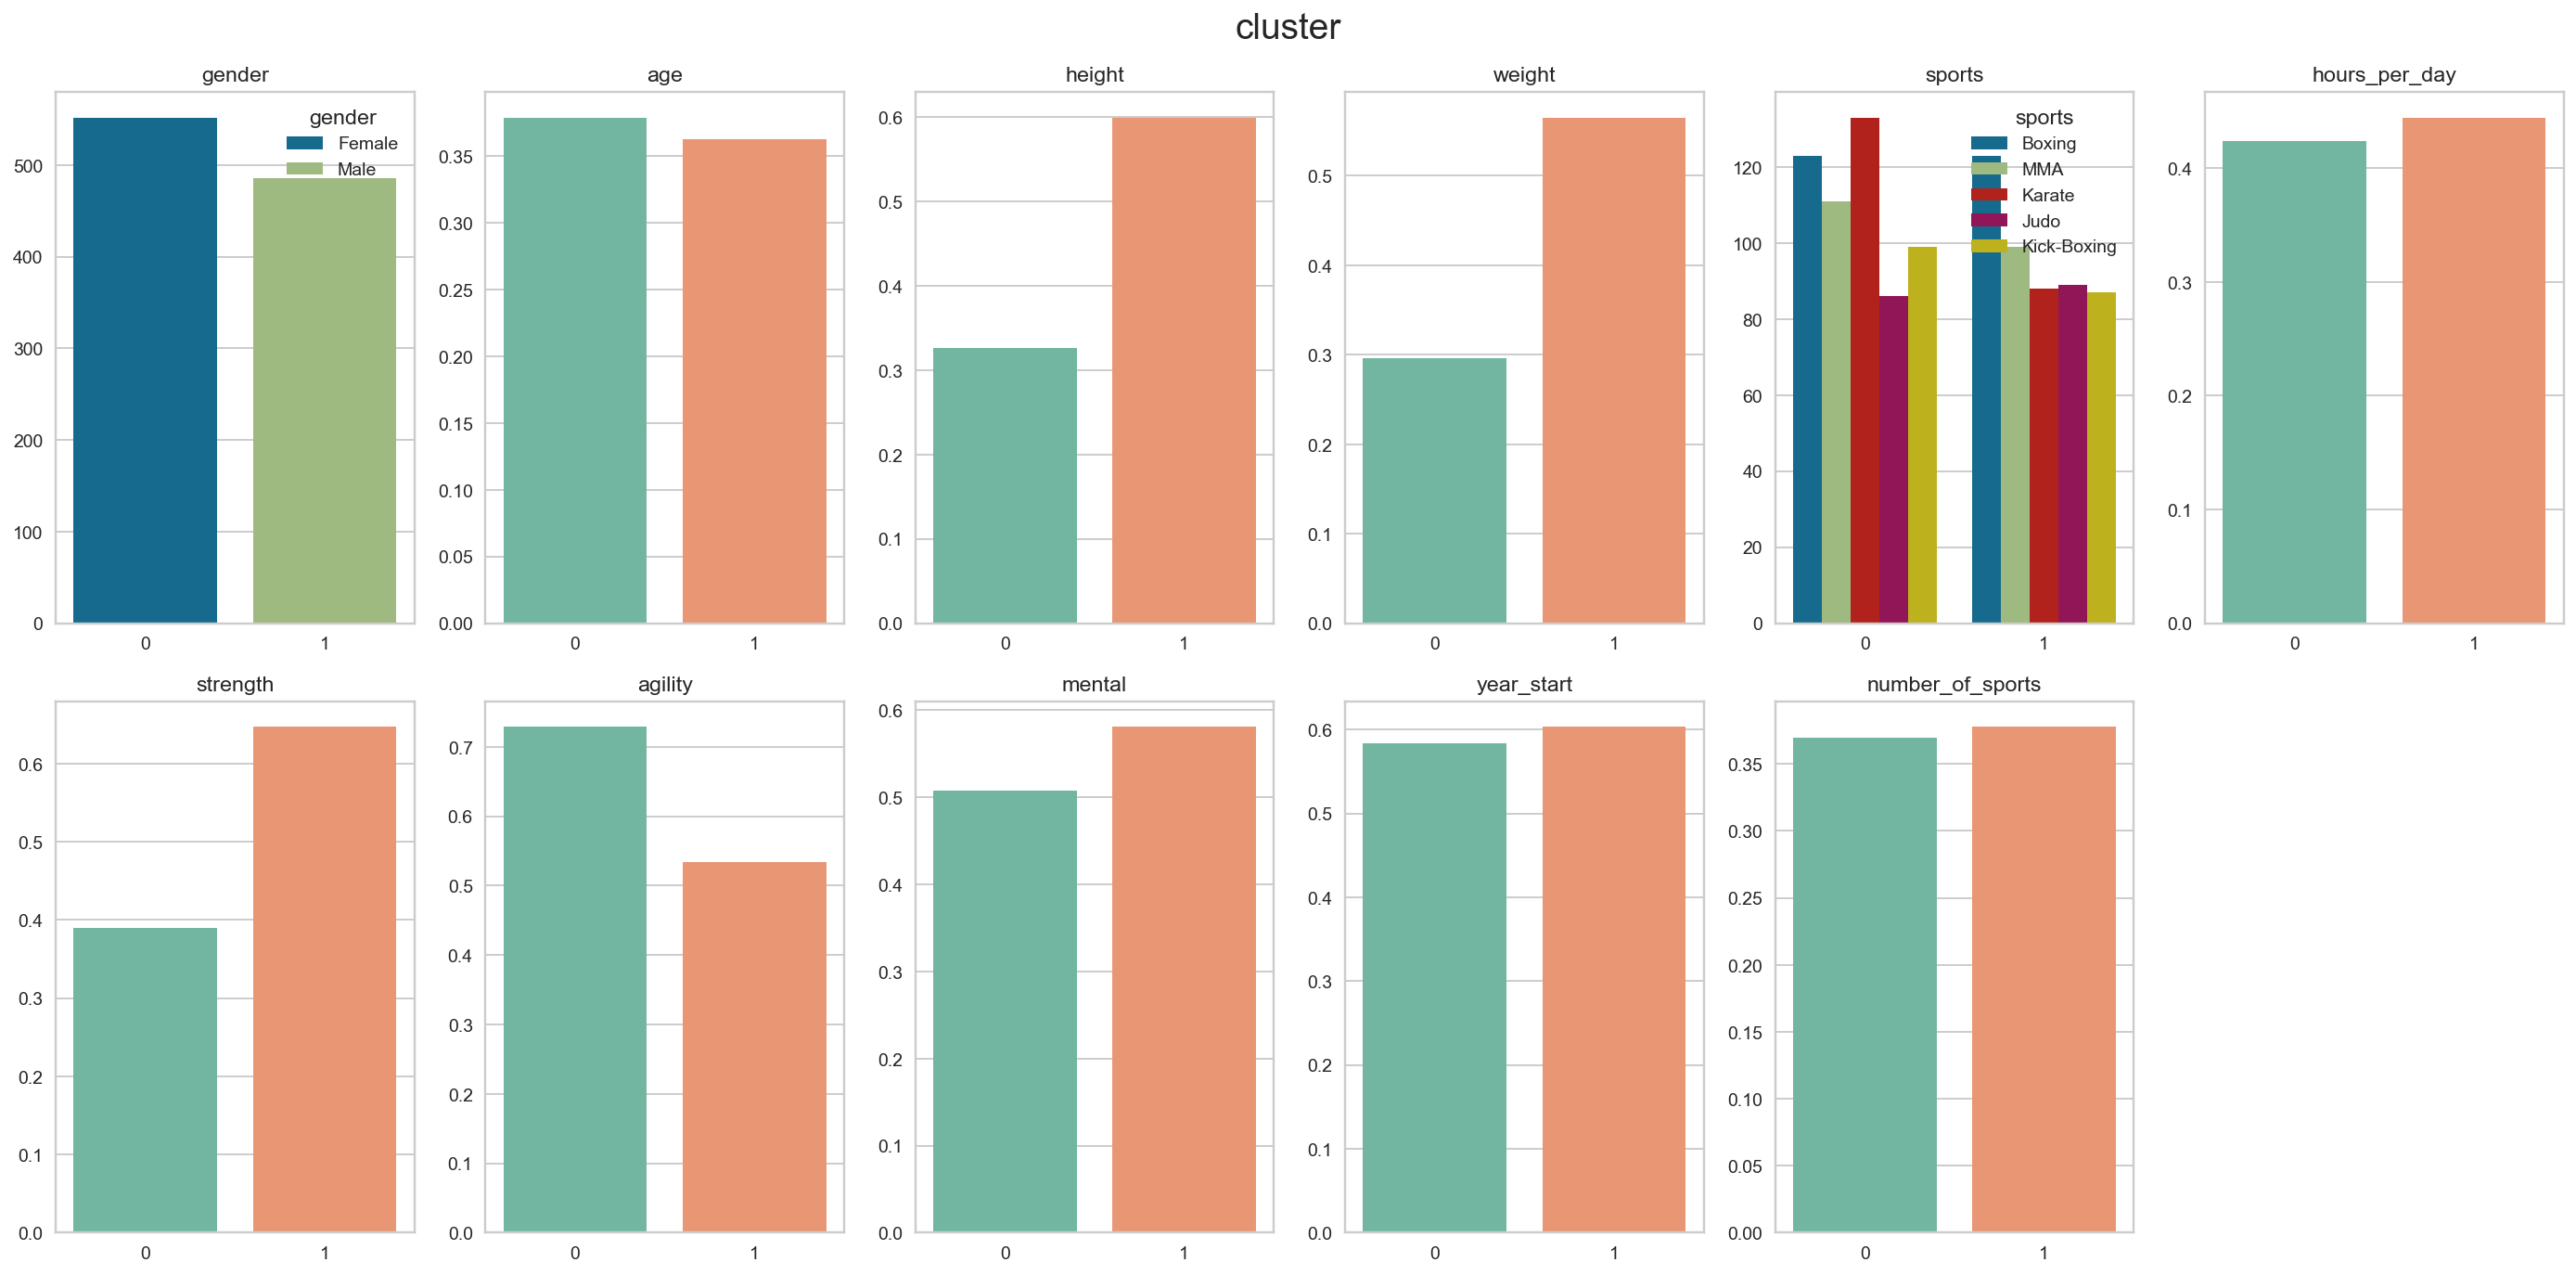

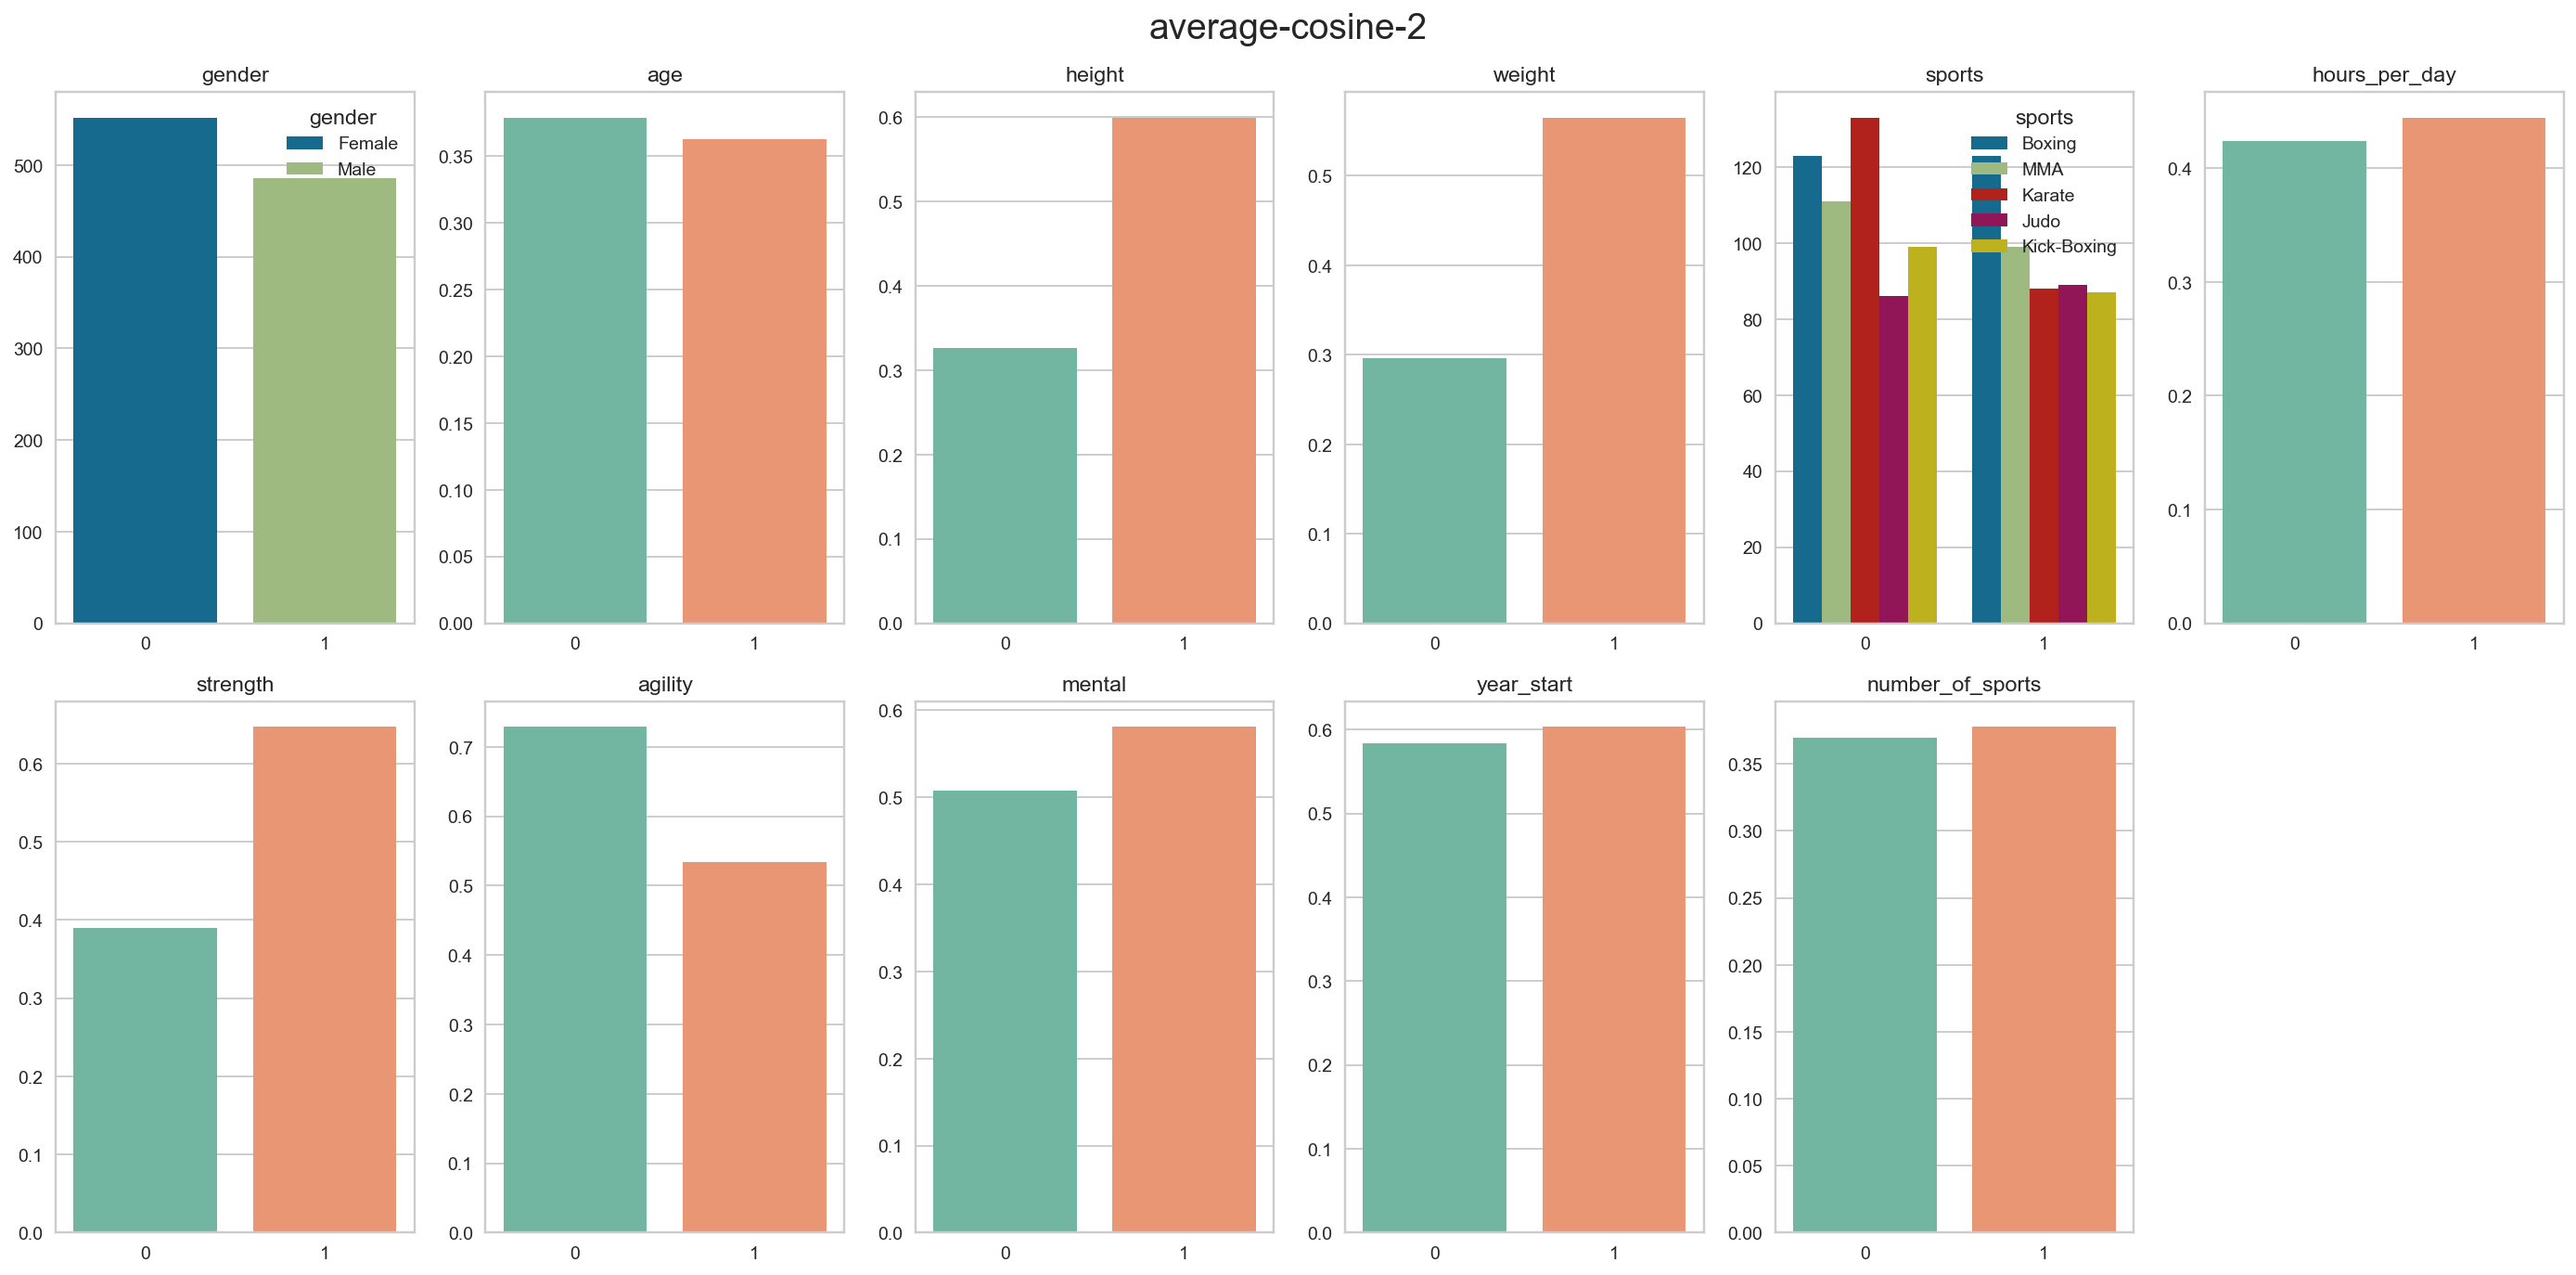

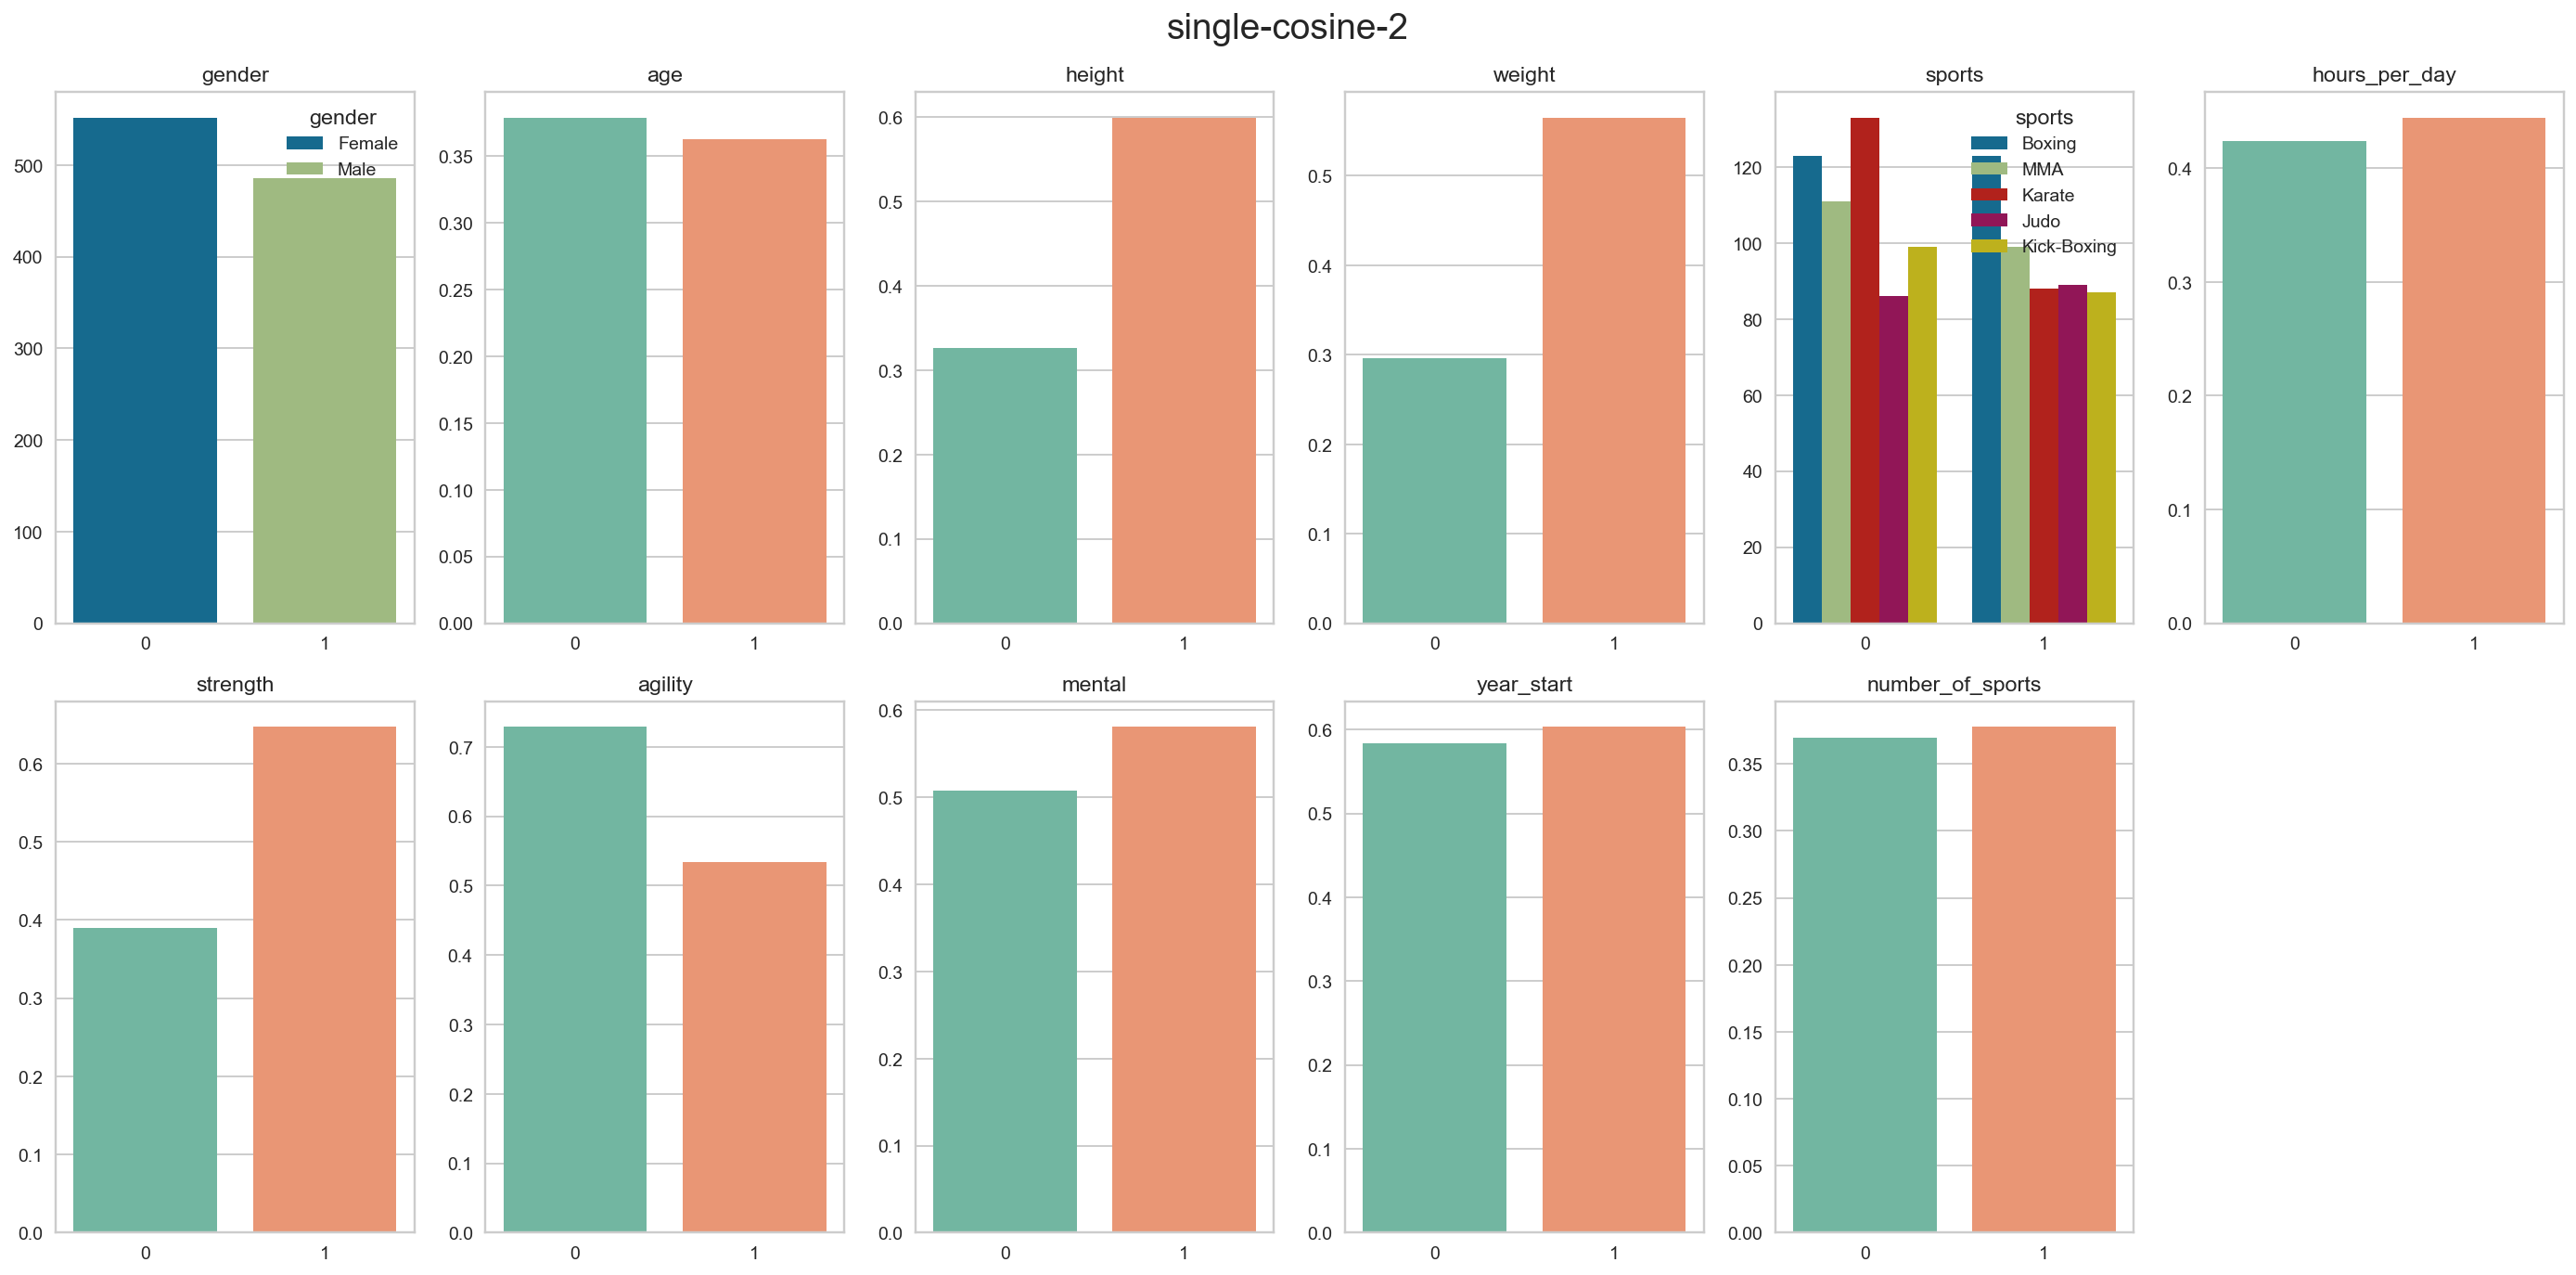

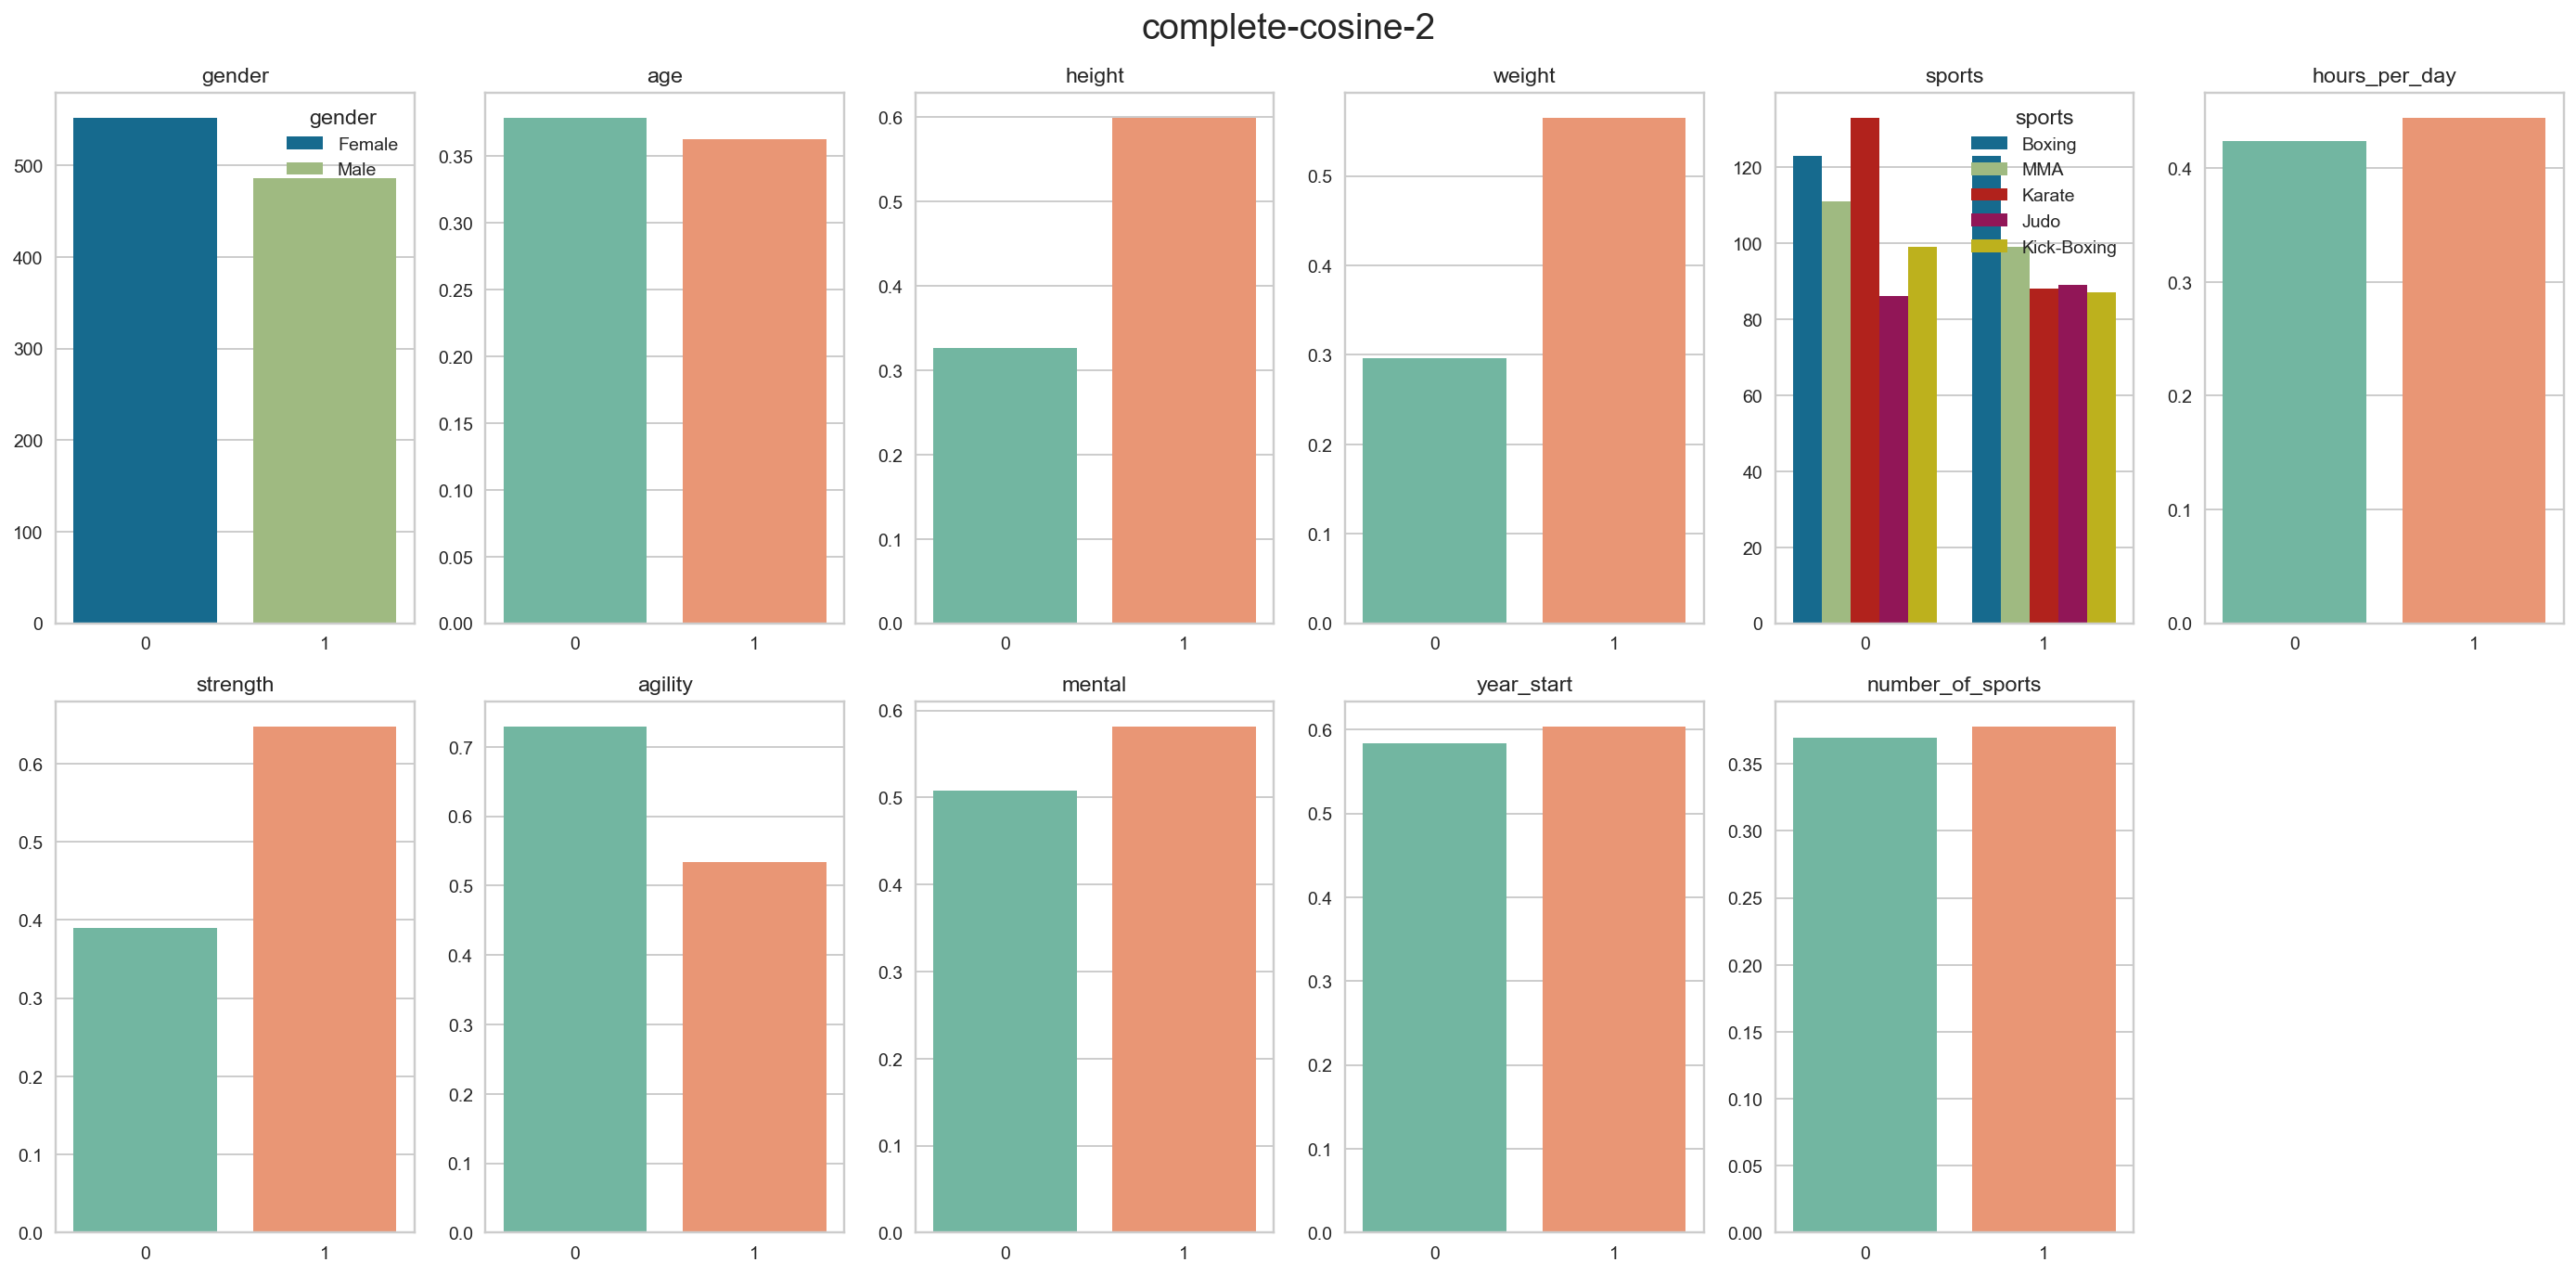

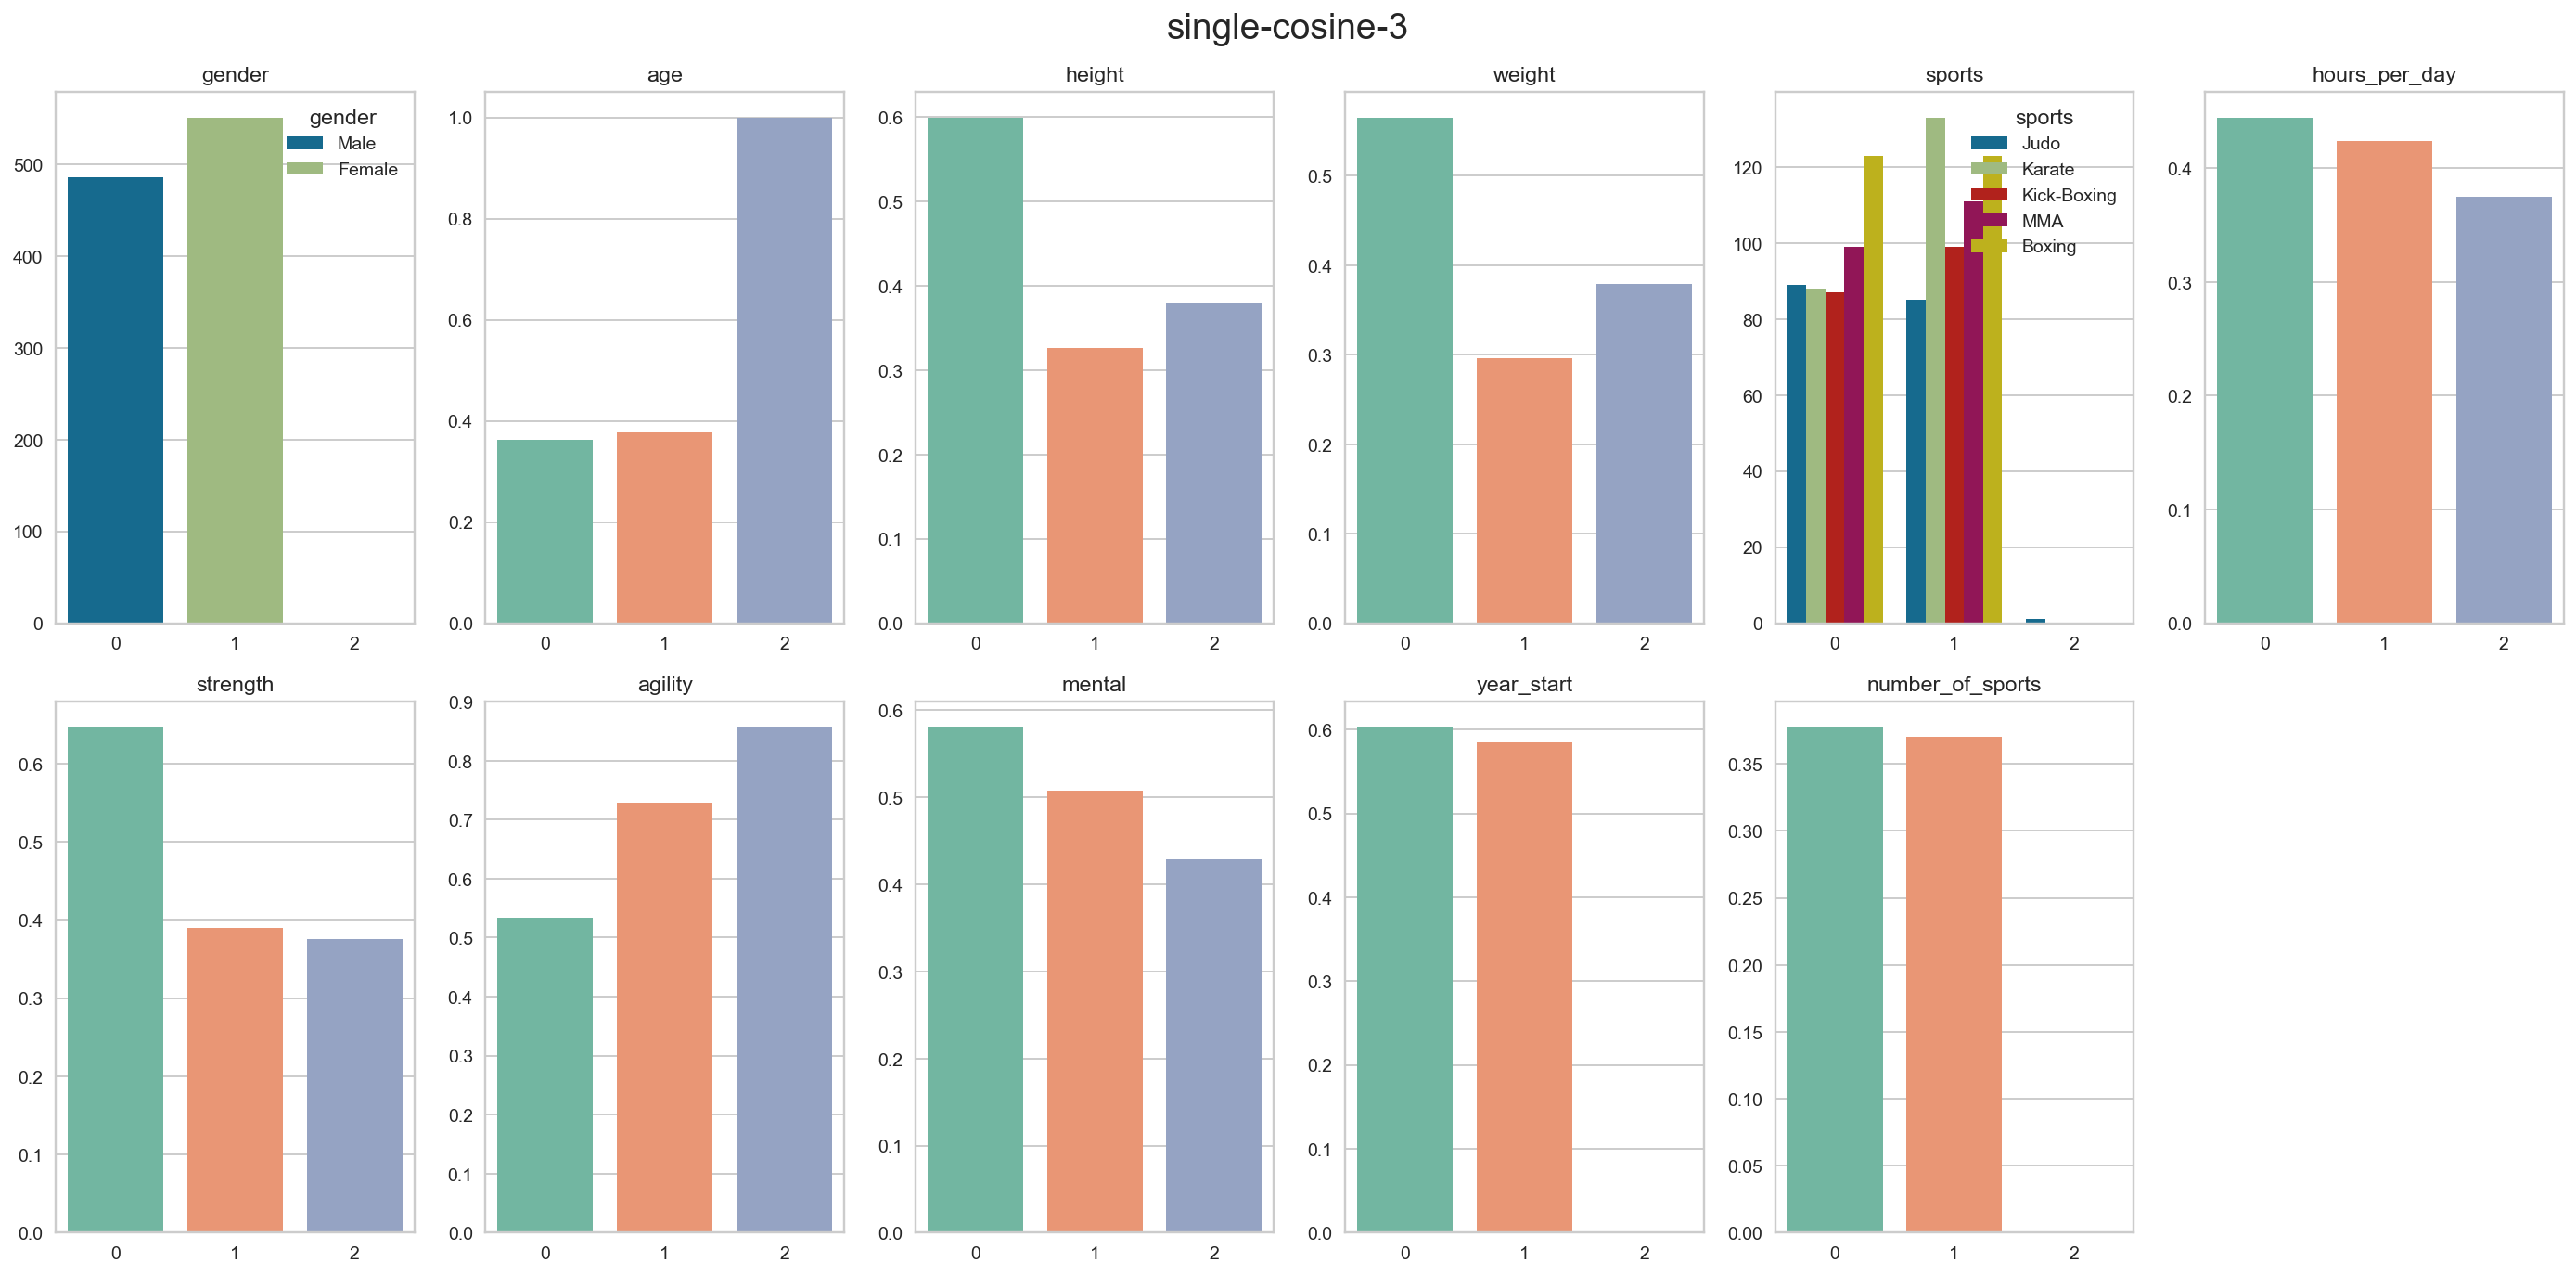

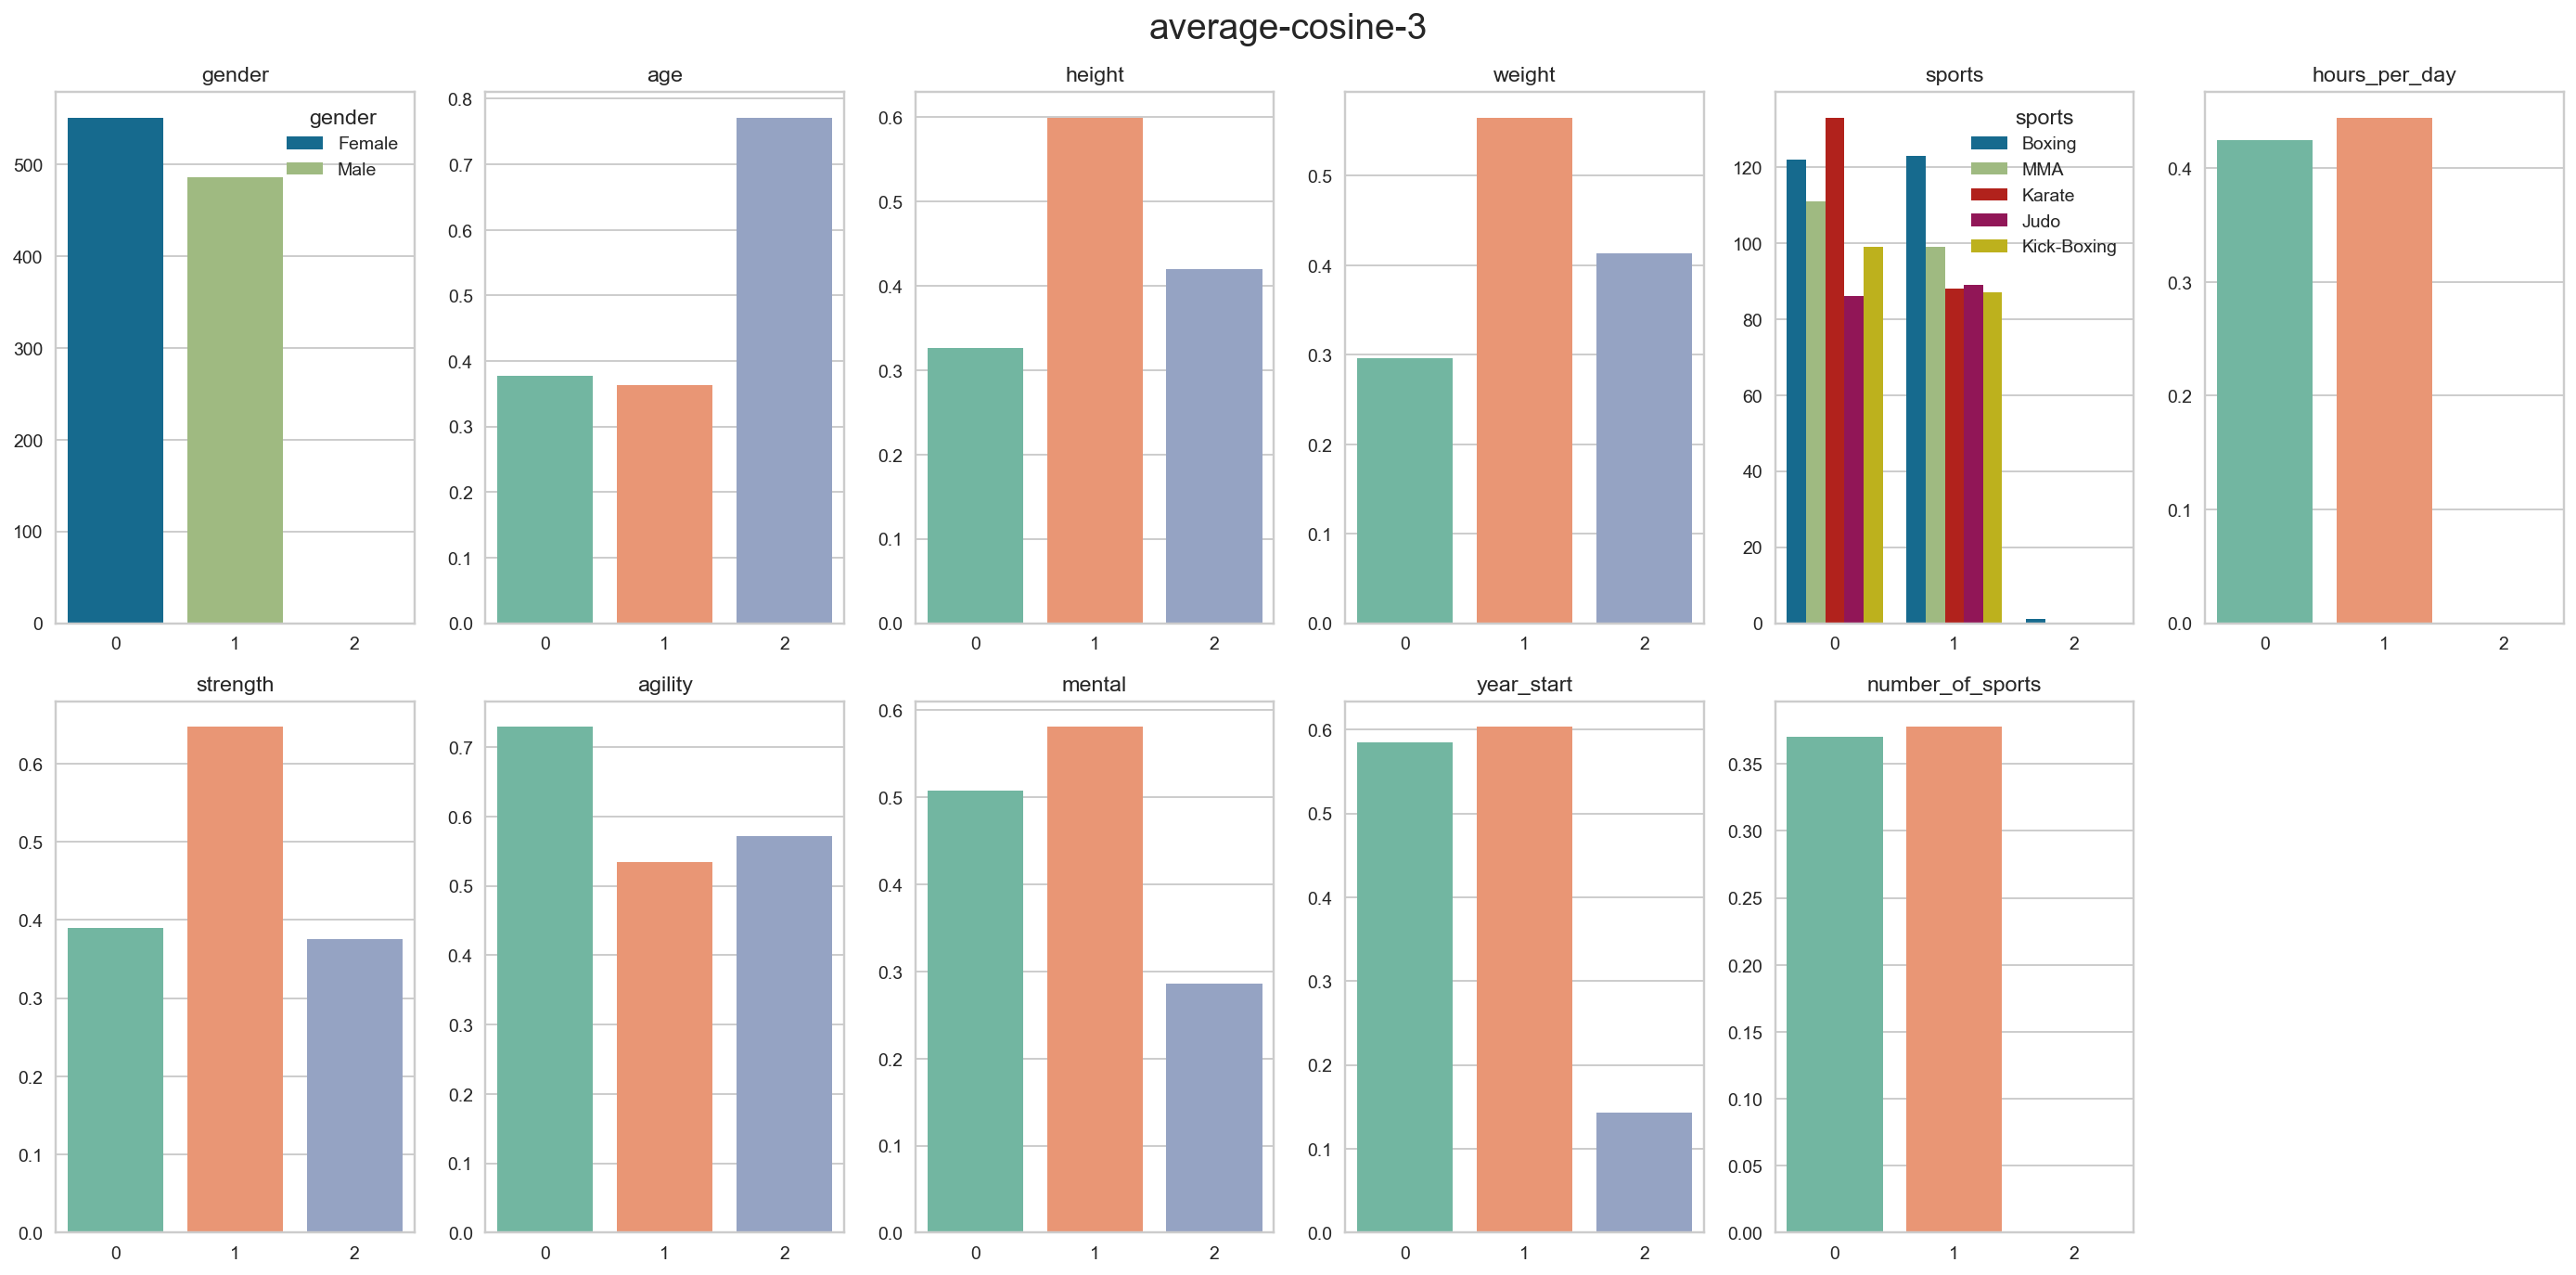

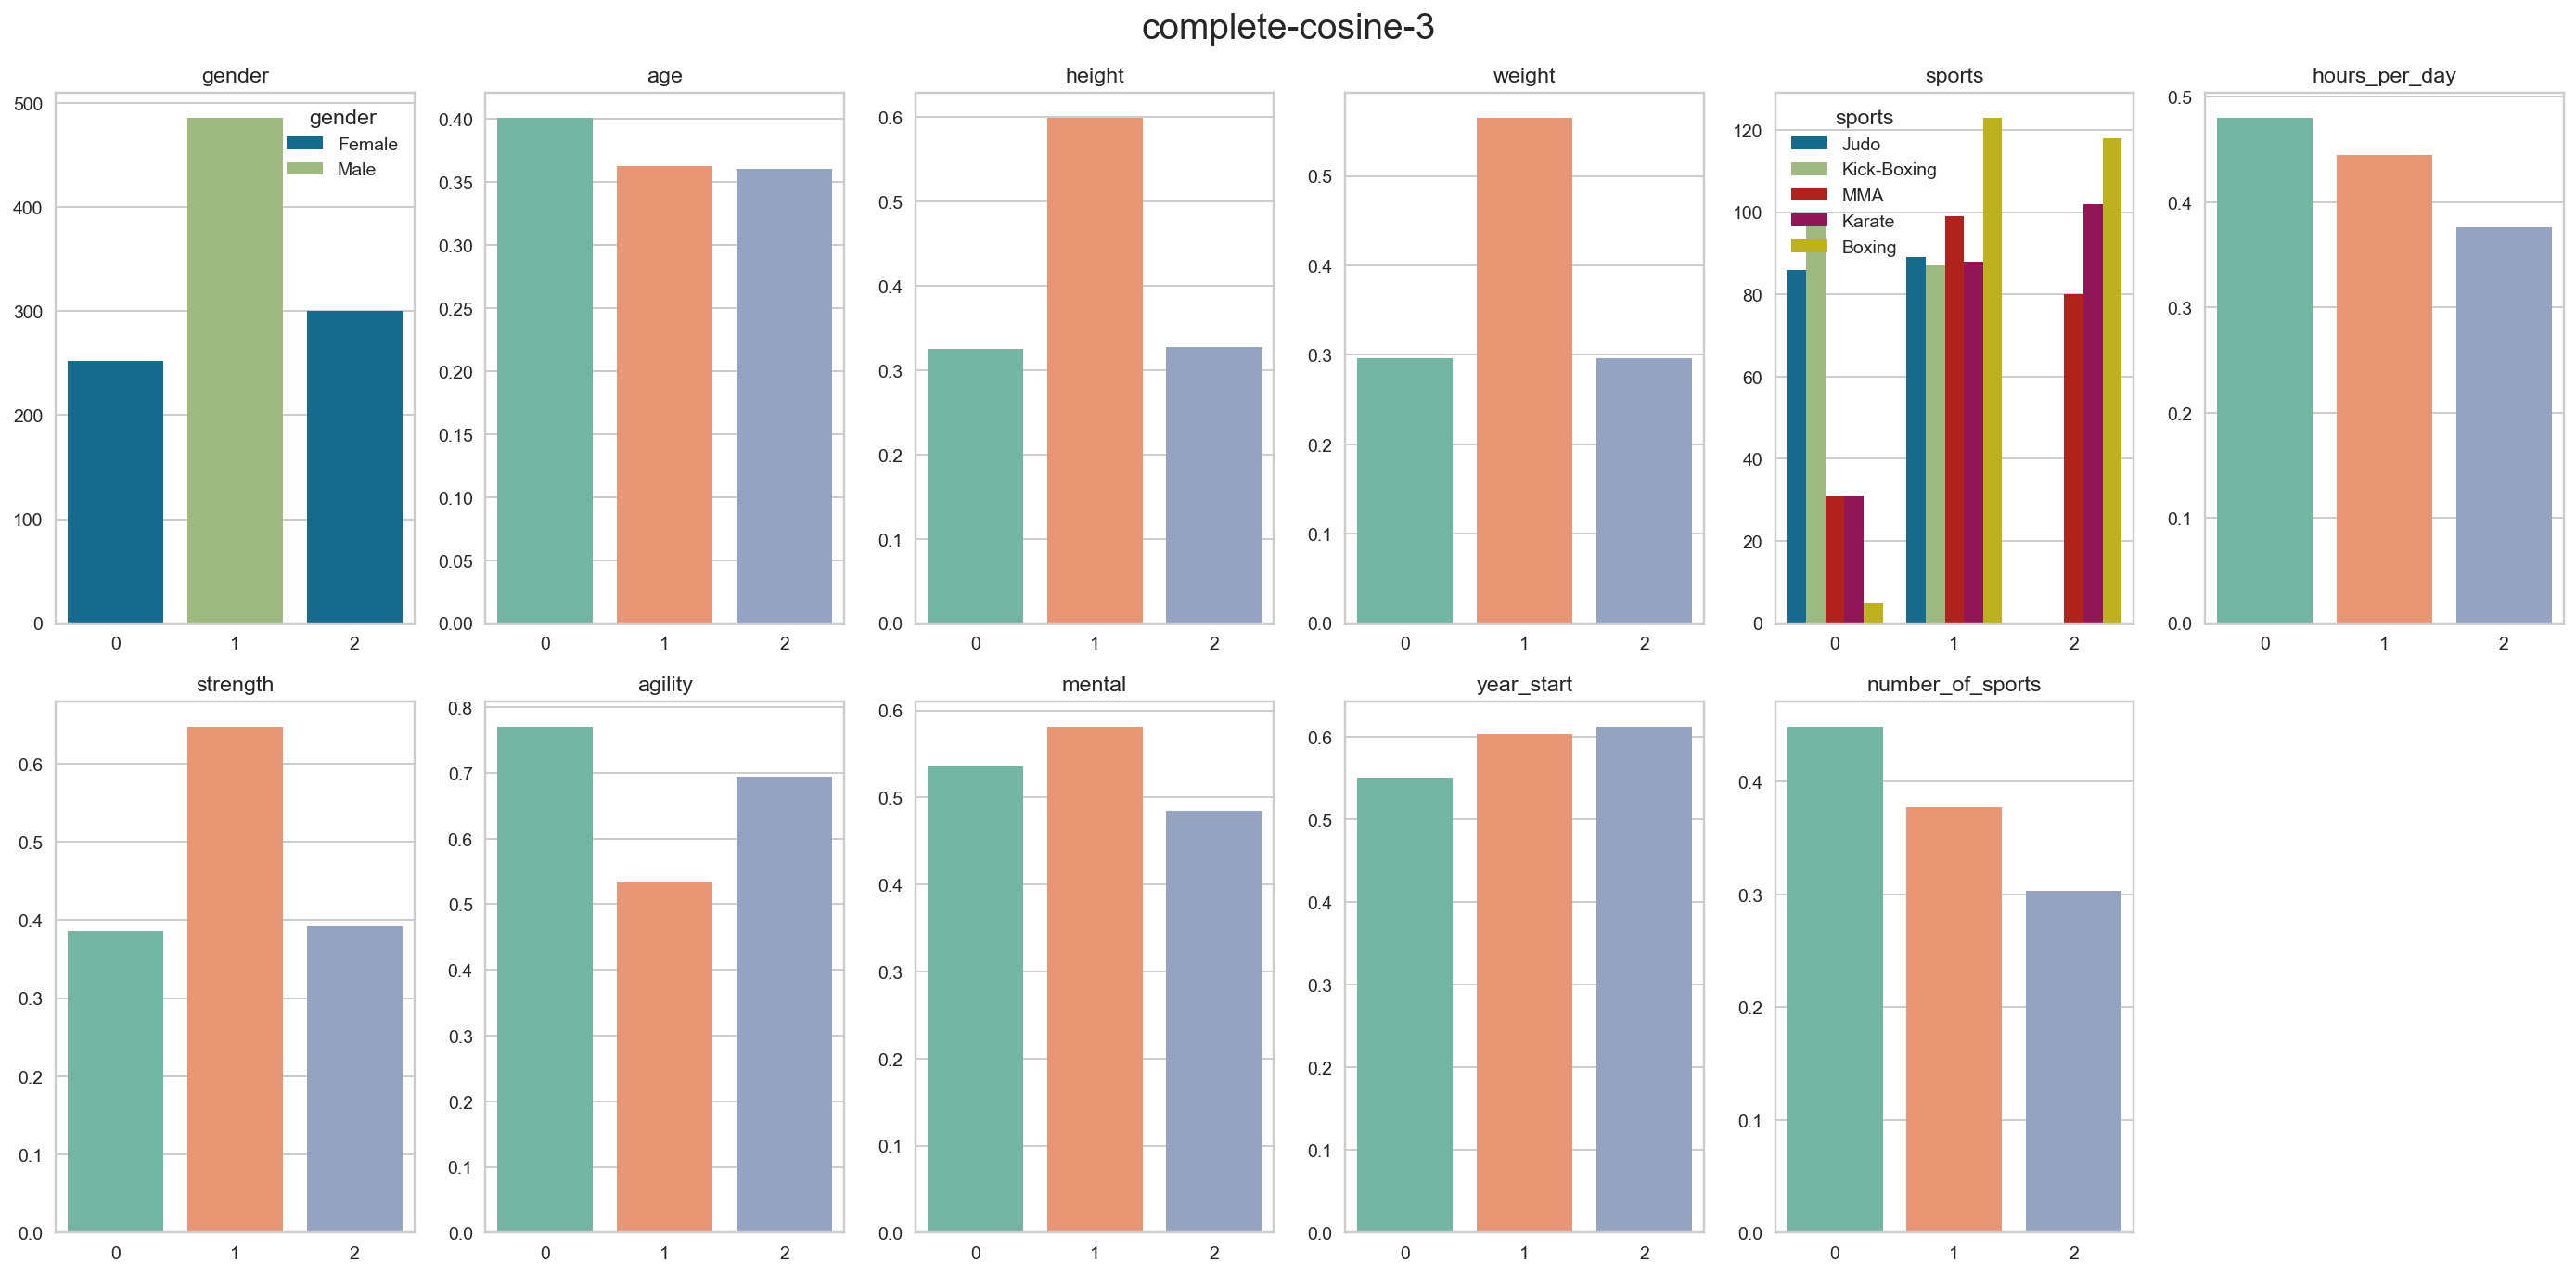

In [217]:
for method in df_with_labels.columns[11:]:
    fig, axes = plt.subplots(nrows = 2, ncols = math.ceil(len(df.columns)/2), figsize = (20,10), dpi = 140)
    axes = axes.flat
    for i, col in enumerate(df_with_labels.columns[:11]):
        if col in num_cols:
            df_grouped = df_with_labels.groupby(method)[col].mean().reset_index()
            sns.barplot(data = df_grouped, x = method, y = col, ax = axes[i], palette = "Set2")
        else:
            sns.countplot(data = df_og, x = df_with_labels[method], ax = axes[i], hue = col)
        axes[i].set_title(col)
        axes[i].set_ylabel("")
        axes[i].set_xlabel("")
        plt.suptitle(method, fontsize = 20)
    plt.delaxes(axes[-1])
    plt.tight_layout()
    
    plt.show()

Vemos que todos los clústeres en todos los métodos agrupan a todos los hombres en un clúster específico (etiqueta de gender = 0). Según el caso ocurre:

- 2 Clústeres: los conjuntos creados corresponden a uno para hombres y otro para mujeres.
- 3 Clústeres: igual que en el caso con 2 clústeres, pero se queda 1 solo registro suelto en un tercer clúster, excepto en complete cosine, donde las mujeres se separan en 2 clústeres de forma bastante equitativa. Sin embargo, no es una clusterización muy óptima, ya que estos dos grupos no presentan mucha diferencia en sus características.

Vamos a realizar una visualización de los clústeres haciendo una reducción de dimensionalidad usando PCA. Este método va a buscar a través de autovectores y autovalores nuevas variables que sean combinaciones de las existentes (comprobando también correlaciones), las cuales sean capaces de explicar las n variables en menos componentes. En nuestro caso usaremos 3 para poder llevar a cabo una visualización intuitiva.

In [218]:
reductor = PCA(n_components=3)
df_reduced = pd.DataFrame(reductor.fit_transform(X = df), columns=["x","y","z"])
df_reduced = pd.concat([df_reduced, df_with_labels[df_with_labels.columns[11:]]], axis = 1)

In [219]:
print(f'Ratio de Varianza explicada por PCA : {sum(reductor.explained_variance_ratio_):.3f}')

Ratio de Varianza explicada por PCA : 0.829


Vemos que esta reducción es bastante satisfactoria, ya que logra explicar al 82.9% la varianza de nuestros datos.

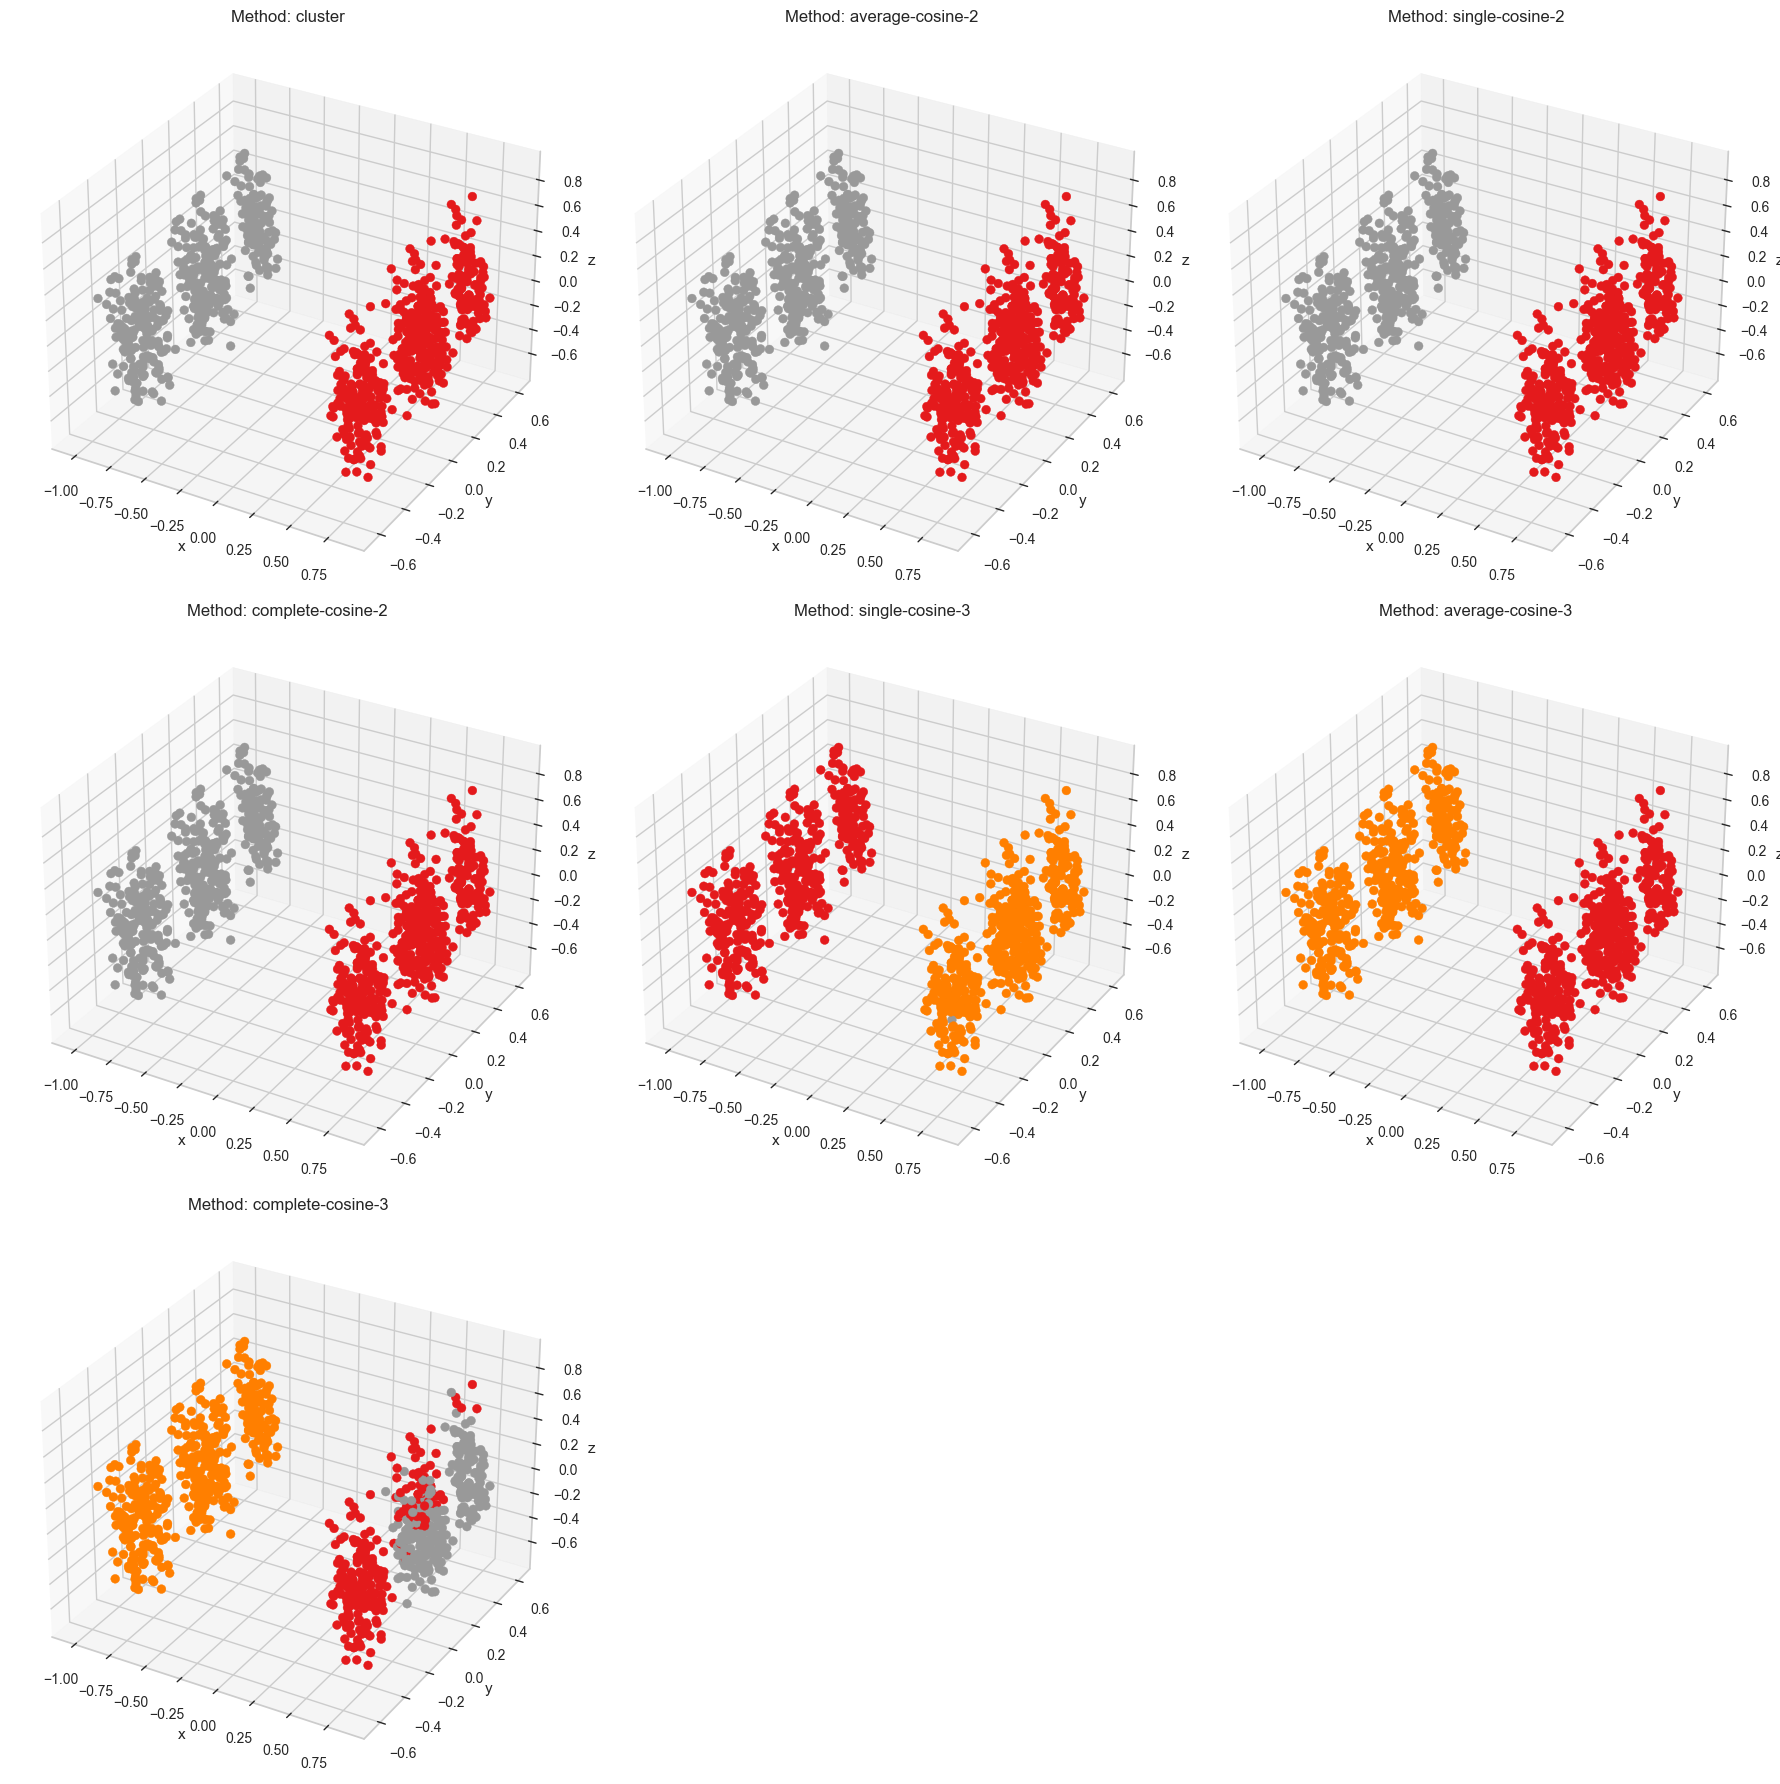

In [220]:
num_methods = len(df_with_labels.columns[11:])

cols = 3 
rows = math.ceil(num_methods / cols)

fig = plt.figure(figsize=(cols * 6, rows * 6))

for i, method in enumerate(df_with_labels.columns[11:]):
    ax = fig.add_subplot(rows, cols, i + 1, projection='3d')
    cmap = plt.get_cmap("Set1")
    x = df_reduced[method]

    sc = ax.scatter(
        df_reduced["x"], 
        df_reduced["y"], 
        df_reduced["z"], 
        s=40, 
        c=x, 
        marker='o', 
        cmap=cmap, 
        alpha=1
    )
    
    ax.set_title(f"Method: {method}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

plt.tight_layout()
plt.show()


Visualmente observamos que los métodos de 2 clusters separan de la misma manera (entre géneros, como visto previamente), mientras que para 3 clusters deja hay bastante solapamiento entre valores. Viendo la representación uno podría pensar que hacer 6 clusters podría ser óptimo y equivalente a clusterizar los dos clusters de los géneros. Podemos probar:

In [221]:
results_df[results_df["n_cluster"] == 6]

,linkage,metric,silhouette_score,davies_bouldin_index,cluster_cardinality,n_cluster
12,average,cosine,0.488764,1.109794,"{0: 486, 1: 364, 2: 2, 3: 3, 4: 182, 5: 1}",6
27,complete,cosine,0.292894,1.996516,"{0: 311, 1: 112, 2: 164, 3: 140, 4: 175, 5: 136}",6
34,single,cosine,0.243241,0.732400,"{0: 548, 1: 485, 2: 1, 3: 1, 4: 2, 5: 1}",6
37,average,chebyshev,0.226304,1.318310,"{0: 186, 1: 359, 2: 176, 3: 309, 4: 7, 5: 1}",6
49,complete,euclidean,0.163704,1.724958,"{0: 267, 1: 182, 2: 105, 3: 126, 4: 265, 5: 93}",6
53,ward,euclidean,0.156057,1.849884,"{0: 248, 1: 167, 2: 199, 3: 135, 4: 103, 5: 186}",6
58,complete,chebyshev,0.146764,1.854338,"{0: 372, 1: 162, 2: 98, 3: 49, 4: 299, 5: 58}",6
60,single,chebyshev,0.144556,2.183431,"{0: 123, 1: 185, 2: 244, 3: 123, 4: 176, 5: 187}",6
61,average,euclidean,0.140653,1.156545,"{0: 476, 1: 549, 2: 3, 3: 3, 4: 4, 5: 3}",6
70,single,euclidean,0.117242,0.873710,"{0: 4, 1: 549, 2: 481, 3: 1, 4: 2, 5: 1}",6


Vemos que opciones como la primera, la tercera o la cuarta no son las que buscamos, ya que no tienen una distribución de cardinalidad muy uniforme. Probaremos con la sexta y la antepenúltima, aunque las métricas no sean las mejores, podríamos seguir teniendo clústeres coherentes.

In [222]:
df_agg6 = df.copy()
for link, metric in [results_df[results_df["n_cluster"] == 6][["linkage", "metric"]].values[i] for i in [5,-3]]:
    agg_6 = AgglomerativeClustering(n_clusters=6, metric = metric, linkage=link )
    agg_6.fit(df)
    df_agg6[f"{link}-{metric}-6"] = agg_6.labels_

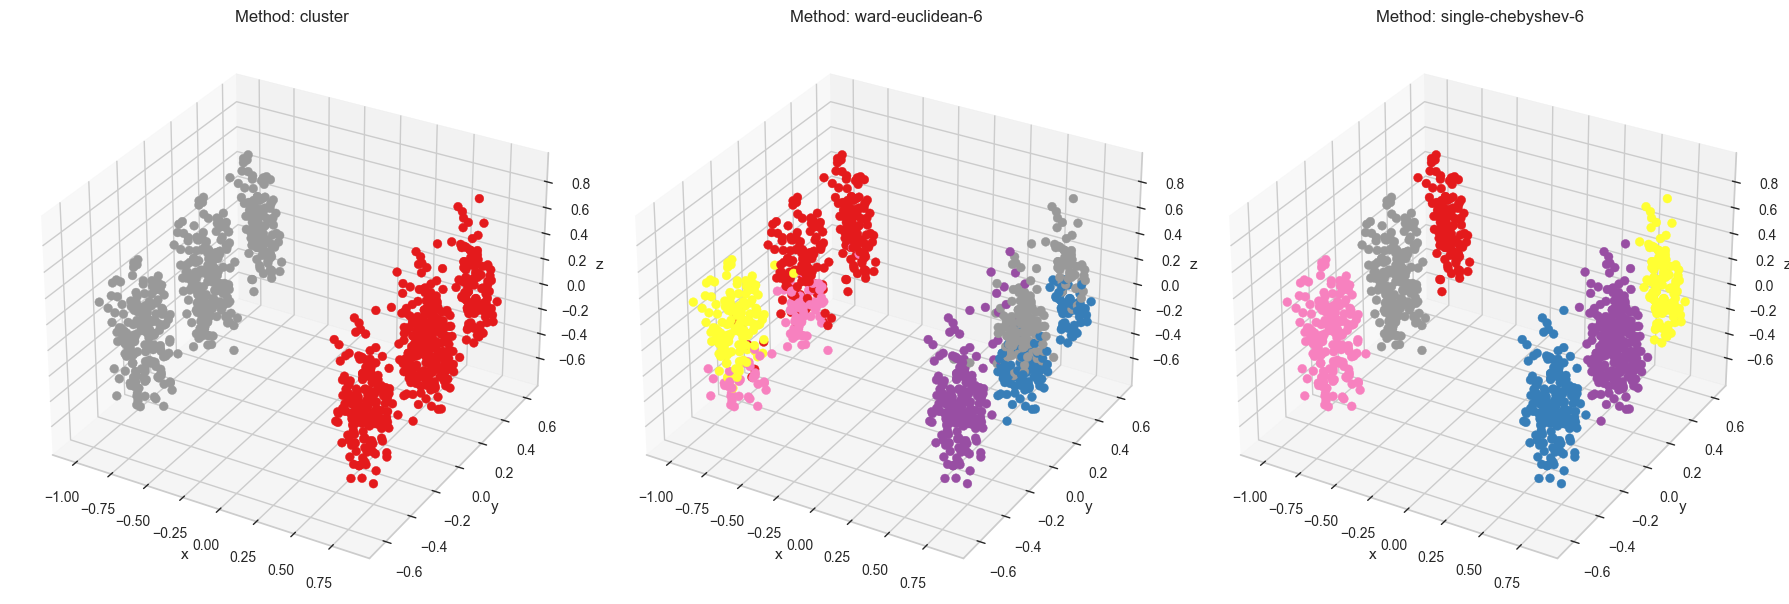

In [223]:
cols = 3 
rows = 1

fig = plt.figure(figsize=(cols * 6, rows * 6))

for i, method in enumerate(df_agg6.columns[11:]):
    ax = fig.add_subplot(rows, cols, i + 1, projection='3d')
    cmap = plt.get_cmap("Set1")
    x = df_agg6[method]

    sc = ax.scatter(
        df_reduced["x"], 
        df_reduced["y"], 
        df_reduced["z"], 
        s=40, 
        c=x, 
        marker='o', 
        cmap=cmap, 
        alpha=1
    )
    
    ax.set_title(f"Method: {method}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

plt.tight_layout()
plt.show()

Vemos que la opción de single chebyshev es la que mejor nos separa nuestros grupos, aun con malas métricas. Vamos a hacer un plot radial para entender las diferencias entre ellos.

In [280]:
df_agg6.head()

,gender,age,height,weight,sports,hours_per_day,strength,agility,mental,year_start,number_of_sports,cluster,ward-euclidean-6,single-chebyshev-6
0,1.0,0.657143,0.26,0.293103,1.000000,0.375,0.625,0.714286,0.571429,0.085714,0.25,0,1,3
1,1.0,0.657143,0.26,0.293103,0.492958,0.375,0.625,0.714286,0.571429,0.085714,0.25,0,5,2
2,0.0,0.514286,0.66,0.603448,0.000000,0.000,0.750,0.285714,0.857143,0.571429,0.00,1,4,4
3,0.0,0.314286,0.53,0.482759,0.647887,0.500,0.750,0.714286,0.571429,0.742857,0.00,1,4,5
4,0.0,0.600000,0.71,0.724138,0.000000,0.375,0.625,0.428571,0.714286,0.485714,0.00,1,3,4


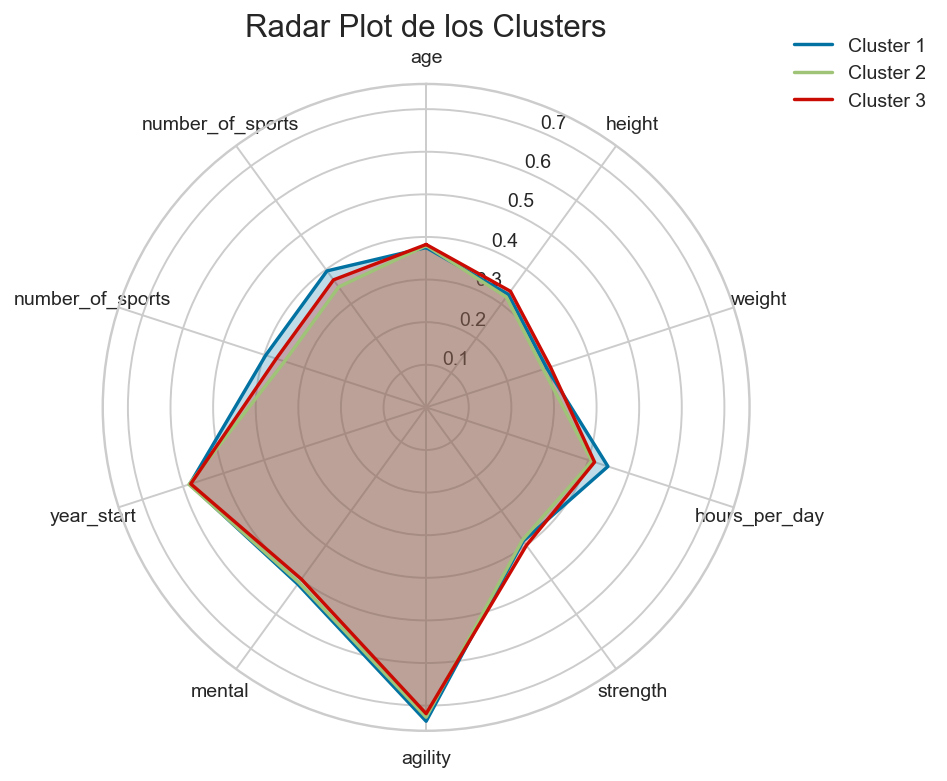

In [ ]:
variables = num_cols

cluster_means = df_agg6[df_agg6["gender"] == 1.0].groupby('single-chebyshev-6')[variables].mean()

# Repetir la primera columna al final para cerrar el radar
cluster_means = pd.concat([cluster_means, cluster_means.iloc[:, 0:1]], axis=1)

# Crear los ángulos para el radar plot
num_vars = len(variables)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Cerrar el gráfico

# Crear el radar plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True), dpi = 140)

# Dibujar un gráfico para cada cluster
for i, row in cluster_means.iterrows():
    ax.plot(angles, row, label=f'Cluster {i}')
    ax.fill(angles, row, alpha=0.25)

# Configurar etiquetas de los ejes
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(variables)

# Añadir leyenda y título
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title('Radar Plot de los Clusters (Mujer)', size=16)
plt.show()

Observamos la razón de las malas métricas: obtenemos grupos poco diferenciados:
- Cluster 1: Son aquellas atletas que dedican más tiempo a la profesión ya que se dedican a más número de deportes.
- Cluster 2: Son aquellas atletas que dedican menos tiempo a la profesión y con menor número de deportes. También son aquellas con menores estadísticas físicas.
- Cluster 3: Son aquellas atletas en mejor condición física (fuerza, altura, peso).

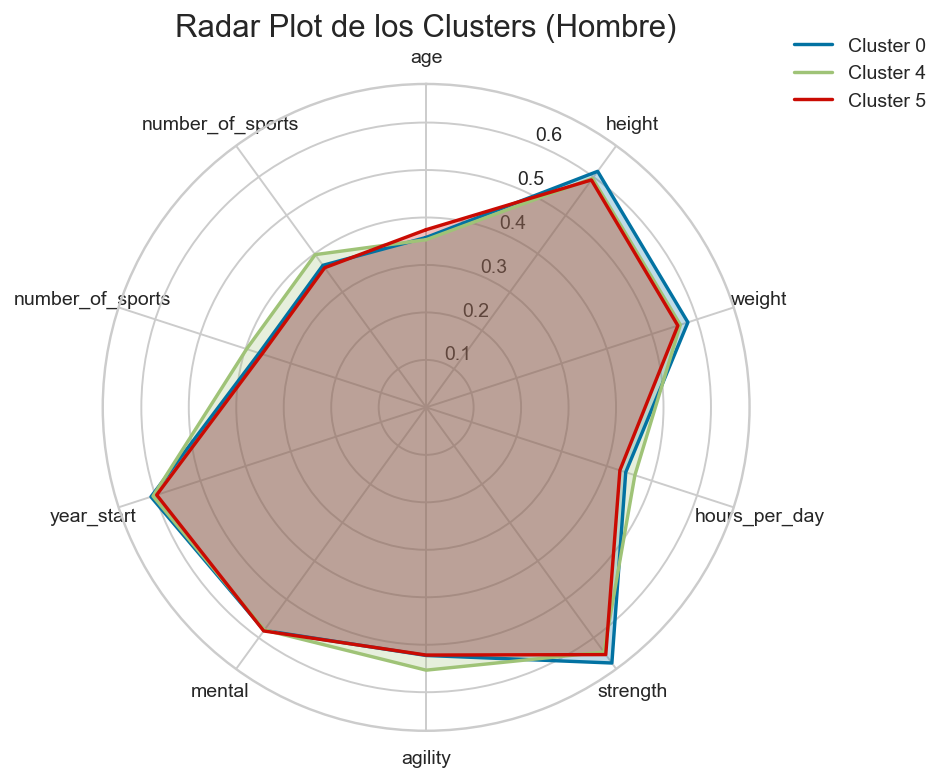

In [232]:
variables = num_cols

cluster_means = df_agg6[df_agg6["gender"] == 0.0].groupby('single-chebyshev-6')[variables].mean()

# Repetir la primera columna al final para cerrar el radar
cluster_means = pd.concat([cluster_means, cluster_means.iloc[:, 0:1]], axis=1)

# Crear los ángulos para el radar plot
num_vars = len(variables)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Cerrar el gráfico

# Crear el radar plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True), dpi = 140)

# Dibujar un gráfico para cada cluster
for i, row in cluster_means.iterrows():
    ax.plot(angles, row, label=f'Cluster {i}')
    ax.fill(angles, row, alpha=0.25)

# Configurar etiquetas de los ejes
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(variables)

# Añadir leyenda y título
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title('Radar Plot de los Clusters (Hombre)', size=16)
plt.show()

En cuanto a los atletas hombres, vemos una clusterización similar:
- Cluster 0: Son aquellos atletas en mejor condición física (fuerza, altura, peso).
- Cluster 4: Son aquellos atletas que dedican más tiempo a la profesión ya que se dedican a más número de deportes. También tienen la mayor agilidad.
- Cluster 5: Son aquellos atletas con menores estadísticas físicas.


Dependiendo del objetivo de la federación en la separación de grupos, esta opción podría ser buena para tener grupos más específicos, aun no siendo tan diferentes.

El método usado hasta ahora ha sidoel clustering jerárquico aglomerativo. Probemos ahora el DBSCAN.

### DBSCAN

Primero empecemos buscando las métricas necesarias (min points y epsilon). Según la documentación y teoría, se suele escoger:
- $\min_{p} \geq D+1$, donde D es la dimensión.
- $\epsilon \approx$ el punto de codo de las distancias a los $k \equiv \min_{p}$ vecinos más cercanos.

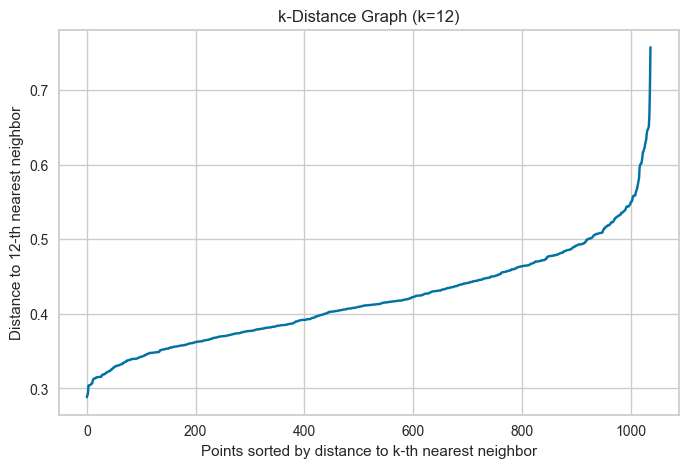

In [251]:
from sklearn.neighbors import NearestNeighbors

k = len(df.columns) # No +1 porque en el df hay una columna de más (los labels del clustering de KMeans)

neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(df[:-1])
distances, indices = neighbors_fit.kneighbors(df[:-1]) # Nos va a devolver las distancias y el índice del k-ésimo vecino más cercano.

# Ordenar las distancias al k-ésimo vecino
distances = np.sort(distances[:, k-1], axis=0)  # Selecciona la distancia del k-ésimo vecino


plt.figure(figsize=(8, 5))
plt.grid()
sns.lineplot(distances)
plt.title(f"k-Distance Graph (k={k})")
plt.xlabel("Points sorted by distance to k-th nearest neighbor")
plt.ylabel(f"Distance to {k}-th nearest neighbor")
plt.grid()
plt.show()

Podemos observar un codo en alrededor de los 0.5 - 0.6. En este rango se situará nuestra épsilon.

In [269]:
distance_metrics = ['euclidean', 'cosine', 'chebyshev']

# Crear un DataFrame para almacenar los resultados
results = []
df_copia = df.copy()
# Suponiendo que tienes un DataFrame llamado df_copia
# Aquí df_copia debería ser tu conjunto de datos
# Asegúrate de que esté preprocesado adecuadamente (normalizado si es necesario)
for metric in distance_metrics:
    for epsilon in np.arange(0.5,0.6, 0.02):
        try:
            # Configurar el modelo de AgglomerativeClustering
            modelo = DBSCAN(min_samples=k, eps = epsilon)

            # Ajustar el modelo
            labels = modelo.fit_predict(df[:-1])
            # Calcular métricas si hay más de un cluster
            if len(np.unique(labels)) > 1:
                # Silhouette Score
                silhouette_avg = silhouette_score(df[:-1], labels, metric=metric)

                # Davies-Bouldin Index
                db_score = davies_bouldin_score(df[:-1], labels)

                
                # Cardinalidad (tamaño de cada cluster)
                cluster_cardinality = {cluster: sum(labels == cluster) for cluster in np.unique(labels)}

            # Almacenar resultados
            results.append({
                'linkage': linkage_method,
                'metric': metric,
                'silhouette_score': silhouette_avg,
                'davies_bouldin_index': db_score,
                'cluster_cardinality': cluster_cardinality,
                'epsilon': epsilon
            })

        except Exception as e:
            print(e)
            # print(f"Error con linkage={linkage_method}, metric={metric}: {e}")

# Crear DataFrame de resultados
results_df_dbscan = pd.DataFrame(results)

# Mostrar resultados ordenados por silhouette_score
results_df_dbscan = results_df_dbscan.sort_values(by='silhouette_score', ascending=False).reset_index(drop = True)

# Mostrar el DataFrame
results_df_dbscan.head(20)

,linkage,metric,silhouette_score,davies_bouldin_index,cluster_cardinality,epsilon
0,single,cosine,0.711452,1.855164,"{-1: 3, 0: 549, 1: 485}",0.54
1,single,cosine,0.698269,2.227634,"{-1: 5, 0: 549, 1: 483}",0.52
2,single,cosine,0.691786,2.359208,"{-1: 7, 0: 482, 1: 548}",0.50
3,single,cosine,0.641623,2.014045,"{-1: 2, 0: 549, 1: 486}",0.56
4,single,cosine,0.623789,0.715893,"{-1: 1, 0: 550, 1: 486}",0.58
5,single,euclidean,0.442025,2.227634,"{-1: 5, 0: 549, 1: 483}",0.52
6,single,euclidean,0.437619,2.359208,"{-1: 7, 0: 482, 1: 548}",0.50
7,single,euclidean,0.421389,1.855164,"{-1: 3, 0: 549, 1: 485}",0.54
8,single,euclidean,0.395484,0.715893,"{-1: 1, 0: 550, 1: 486}",0.58
9,single,euclidean,0.389391,2.014045,"{-1: 2, 0: 549, 1: 486}",0.56


Vemos que en este caso el DBSCAN nos clusteriza en 2 clusters (además de los outliers). Veamos si siguen el mismo patrón de género que en los casos anteriores:

In [271]:
modelo = DBSCAN(min_samples=k, eps = 0.54)
labels = modelo.fit_predict(df[:-1])

df_dbscan = df[:-1].copy()
df_dbscan["dbscan_clusters"] = labels

In [279]:
df_dbscan.groupby(["dbscan_clusters", "gender"])["gender"].value_counts().reset_index()

,dbscan_clusters,gender,count
0,-1,0.0,1
1,-1,1.0,2
2,0,1.0,549
3,1,0.0,485


Parece que sigue agrupando por géneros, pero en este caso nos saca 3 outliers de los datos. Esto podría ser útil si la federación buscara encontrar aquellos atletas excepcionales.

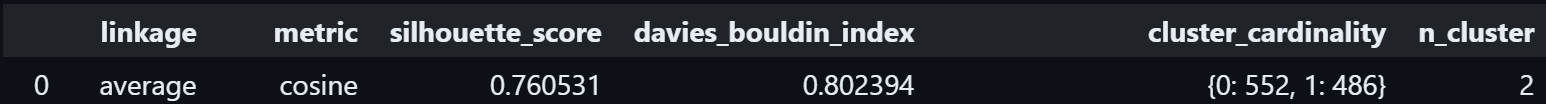

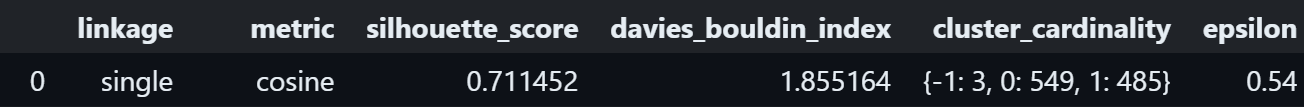

Vemos que las métricas son extrañamente muy dispares, a pesar de formar clusters similares. Esto puede deberse a que el DBSCAN forma un cluster extra que incluye los outliers, lo que provoca que el silhouette baje en consecuencia de la menor compactación y peor separación y el davies bouldin index baja por la alta dispersión.